# Segmentación de Clientes y Modelado por Grupo (Enfoque 2)

Esta sección presenta el segundo enfoque del análisis, basado en la agrupación de clientes con comportamientos operativos similares para la detección de anomalías. A diferencia del enfoque individual, aquí se agrupan los clientes en función de características estadísticas o patrones de consumo, lo que permite aplicar modelos comunes a cada grupo.

El objetivo es reducir la complejidad del modelado manteniendo un buen nivel de precisión en la identificación de anomalías. Para ello, se implementan técnicas de agrupamiento y se entrenan modelos representativos por grupo, evaluando su capacidad para generalizar el comportamiento esperado y detectar desviaciones significativas dentro de cada conjunto.

## Librerias

In [1]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.cluster import KMeans


sns.set(style="whitegrid")


## Cargue de los datos

In [ ]:
DB_PATH = "../db/optigas.db"
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM gold_lecturas_completas WHERE timestamp >= '2023-01-01'", conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
conn.close()

df.head()

timestamp    presion  temperatura    volumen cliente_id
0 2023-01-01 00:00:00  17.562727    25.901493  15.179892   CLIENTE1
1 2023-01-01 01:00:00  17.555539    26.060148  14.659968   CLIENTE1
2 2023-01-01 02:00:00  17.541394    25.273259  13.667327   CLIENTE1
3 2023-01-01 03:00:00  17.549180    25.373352  13.507955   CLIENTE1
4 2023-01-01 04:00:00  17.555836    25.471712  11.532549   CLIENTE1

In [ ]:
fechas_min_max = df.groupby('cliente_id')['timestamp'].agg(['min', 'max']).reset_index()
fechas_min_max.rename(columns={'min': 'fecha_minima', 'max': 'fecha_maxima'}, inplace=True)
fechas_min_max

cliente_id        fecha_minima        fecha_maxima
0    CLIENTE1 2023-01-01 00:00:00 2023-12-31 23:00:00
1   CLIENTE10 2023-01-01 00:00:00 2023-12-31 23:00:00
2   CLIENTE11 2023-01-01 00:00:00 2023-12-31 23:00:00
3   CLIENTE12 2023-01-01 00:00:00 2023-12-31 23:00:00
4   CLIENTE13 2023-01-01 00:00:00 2023-12-31 23:00:00
5   CLIENTE14 2023-01-01 00:00:00 2023-12-31 23:00:00
6   CLIENTE15 2023-01-01 00:00:00 2023-12-31 23:00:00
7   CLIENTE16 2023-01-01 00:00:00 2023-12-31 23:00:00
8   CLIENTE17 2023-01-01 00:00:00 2023-12-31 23:00:00
9   CLIENTE18 2023-01-02 07:00:00 2023-12-31 23:00:00
10  CLIENTE19 2023-01-01 00:00:00 2023-12-31 23:00:00
11   CLIENTE2 2023-01-02 07:00:00 2023-12-31 23:00:00
12  CLIENTE20 2023-01-01 00:00:00 2023-12-31 23:00:00
13   CLIENTE3 2023-01-01 00:00:00 2023-12-31 23:00:00
14   CLIENTE4 2023-01-01 00:00:00 2023-12-31 23:00:00
15   CLIENTE5 2023-01-01 00:00:00 2023-12-31 23:00:00
16   CLIENTE6 2023-01-01 00:00:00 2023-12-31 23:00:00
17   CLIENTE7 2023-01-01 00:00:00 2023-12-31 23:00:00
18   CLIENTE8 2023-01-01 00:00:00 2023-12-31 23:00:00
19   CLIENTE9 2023-01-01 00:00:00 2023-12-31 23:00:00

***
Grupos manual 10 - 10 

In [ ]:
# Ruta relativa desde notebooks/ hacia src/
ruta_modelos = os.path.join("..", "src", "modelos")
os.makedirs(ruta_modelos, exist_ok=True)

In [ ]:
# Segmentos definidos
grupo1 = ['CLIENTE1', 'CLIENTE2', 'CLIENTE4', 'CLIENTE5', 'CLIENTE6', 'CLIENTE14', 'CLIENTE17', 'CLIENTE18', 'CLIENTE19', 'CLIENTE20']  # caída en presión
grupo2 = ['CLIENTE3', 'CLIENTE7', 'CLIENTE8', 'CLIENTE9', 'CLIENTE10', 'CLIENTE11', 'CLIENTE12', 'CLIENTE13', 'CLIENTE15', 'CLIENTE16']  # sin tendencia
grupos = {"grupo1": grupo1, "grupo2": grupo2}


# Detección y visualización
resultados = []

for nombre_grupo, clientes in grupos.items():
    df_grupo = df[df["cliente_id"].isin(clientes)].dropna(subset=["volumen", "presion", "temperatura"]).copy()

    # Línea para pruebas: usar solo una muestra aleatoria
    #df_grupo = df_grupo.sample(20000, random_state=42)  # <-- descomenta para pruebas

    X = df_grupo[["volumen", "presion", "temperatura"]]

    print(f"Entrenando modelos para {nombre_grupo} con {len(X)} registros...")

    # Escalado (una vez por grupo)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Guardar scaler
    ruta_scaler = os.path.join(ruta_modelos, f"scaler_dbscan_{nombre_grupo}.joblib")
    joblib.dump(scaler, ruta_scaler)

    # Isolation Forest (sobre datos escalados)
    iso_model = IsolationForest(contamination=0.03, random_state=42)
    iso_model.fit(X_scaled)
    df_grupo["anomalia_iso"] = pd.Series(iso_model.predict(X_scaled)).map({1: 0, -1: 1})


    ruta_iso = os.path.join(ruta_modelos, f"isolation_forest_{nombre_grupo}.joblib")
    joblib.dump(iso_model, ruta_iso)

    # One-Class SVM
    oc_svm = OneClassSVM(nu=0.03, kernel="rbf", gamma="scale")
    oc_svm.fit(X_scaled)
    df_grupo["anomalia_svm"] = pd.Series(oc_svm.predict(X_scaled)).map({1: 0, -1: 1})

    ruta_svm = os.path.join(ruta_modelos, f"oneclass_svm_{nombre_grupo}.joblib")
    joblib.dump(oc_svm, ruta_svm)

    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=10)
    etiquetas = dbscan.fit_predict(X_scaled)
    df_grupo["anomalia_dbscan"] = (etiquetas == -1).astype(int)

    ruta_dbscan = os.path.join(ruta_modelos, f"dbscan_{nombre_grupo}.joblib")
    joblib.dump(dbscan, ruta_dbscan)

    # Añadir columna de grupo
    df_grupo["grupo"] = nombre_grupo
    resultados.append(df_grupo)

    # Conteo de anomalías
    print(f"Anomalías detectadas en {nombre_grupo} - Isolation Forest: {df_grupo['anomalia_iso'].sum()}, One-Class SVM: {df_grupo['anomalia_svm'].sum()}, DBSCAN: {df_grupo['anomalia_dbscan'].sum()}")

# Concatenar resultados
df_anomalias = pd.concat(resultados)



Entrenando modelos para grupo1 con 86190 registros...
Anomalías detectadas en grupo1 - Isolation Forest: 707.0, One-Class SVM: 867.0, DBSCAN: 26
Entrenando modelos para grupo2 con 84924 registros...
Anomalías detectadas en grupo2 - Isolation Forest: 2115.0, One-Class SVM: 2095.0, DBSCAN: 6


In [ ]:
df_anomalias.head()


timestamp    presion  temperatura    volumen cliente_id  \
0 2023-01-01 00:00:00  17.562727    25.901493  15.179892   CLIENTE1   
1 2023-01-01 01:00:00  17.555539    26.060148  14.659968   CLIENTE1   
2 2023-01-01 02:00:00  17.541394    25.273259  13.667327   CLIENTE1   
3 2023-01-01 03:00:00  17.549180    25.373352  13.507955   CLIENTE1   
4 2023-01-01 04:00:00  17.555836    25.471712  11.532549   CLIENTE1   

   anomalia_iso  anomalia_svm  anomalia_dbscan   grupo  
0           0.0           0.0                0  grupo1  
1           0.0           0.0                0  grupo1  
2           0.0           0.0                0  grupo1  
3           0.0           0.0                0  grupo1  
4           0.0           0.0                0  grupo1

In [ ]:
def graficar_anomalias_grupos(df, lista_clientes, 
                                modelos={'IsolationForest': 'anomalia_iso', 
                                         'OneClassSVM': 'anomalia_svm', 
                                         'DBSCAN': 'anomalia_dbscan'},
                                colores={'IsolationForest': 'orange', 
                                         'OneClassSVM': 'green', 
                                         'DBSCAN': 'red'}):
    """
    Genera gráficos de anomalías por cliente, variable y modelo.
    
    df: DataFrame con las variables y columnas de anomalías
    lista_clientes: lista ordenada de clientes a graficar
    modelos: diccionario de nombre modelo -> columna en df
    colores: diccionario de nombre modelo -> color para el gráfico
    """
    df = df.copy()  # ← Añadir esta línea al inicio de la función
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    for cliente_id in lista_clientes:
        cliente_data = df[df['cliente_id'] == cliente_id]
        if cliente_data.empty:
            print(f"⚠️ Advertencia: Cliente {cliente_id} no encontrado.")
            continue

        num_modelos = len(modelos)
        fig, axs = plt.subplots(3, num_modelos, figsize=(5*num_modelos, 12), sharex=True, sharey=False)

        if num_modelos == 1:
            axs = axs.reshape(3, 1)

        for i, (modelo, col_anomalia) in enumerate(modelos.items()):
            for j, var in enumerate(['presion', 'temperatura', 'volumen']):
                ax = axs[j, i]
                ax.plot(cliente_data.index, cliente_data[var], label=var.capitalize(), color='blue', linewidth=1)

                if col_anomalia in cliente_data.columns:
                    anomalías = cliente_data[cliente_data[col_anomalia] == 1]
                    ax.scatter(anomalías.index, anomalías[var], label=f'Anomalías {modelo}', 
                               color=colores[modelo], s=25)

                ax.set_title(f'{var.capitalize()} - {modelo}')
                ax.set_xlabel('Fecha')
                ax.grid(True)
                if i == 0:
                    ax.set_ylabel(var.capitalize())
                ax.legend()

                y_min, y_max = cliente_data[var].min(), cliente_data[var].max()
                ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))

        plt.suptitle(f'Anomalías detectadas para Cliente {cliente_id}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


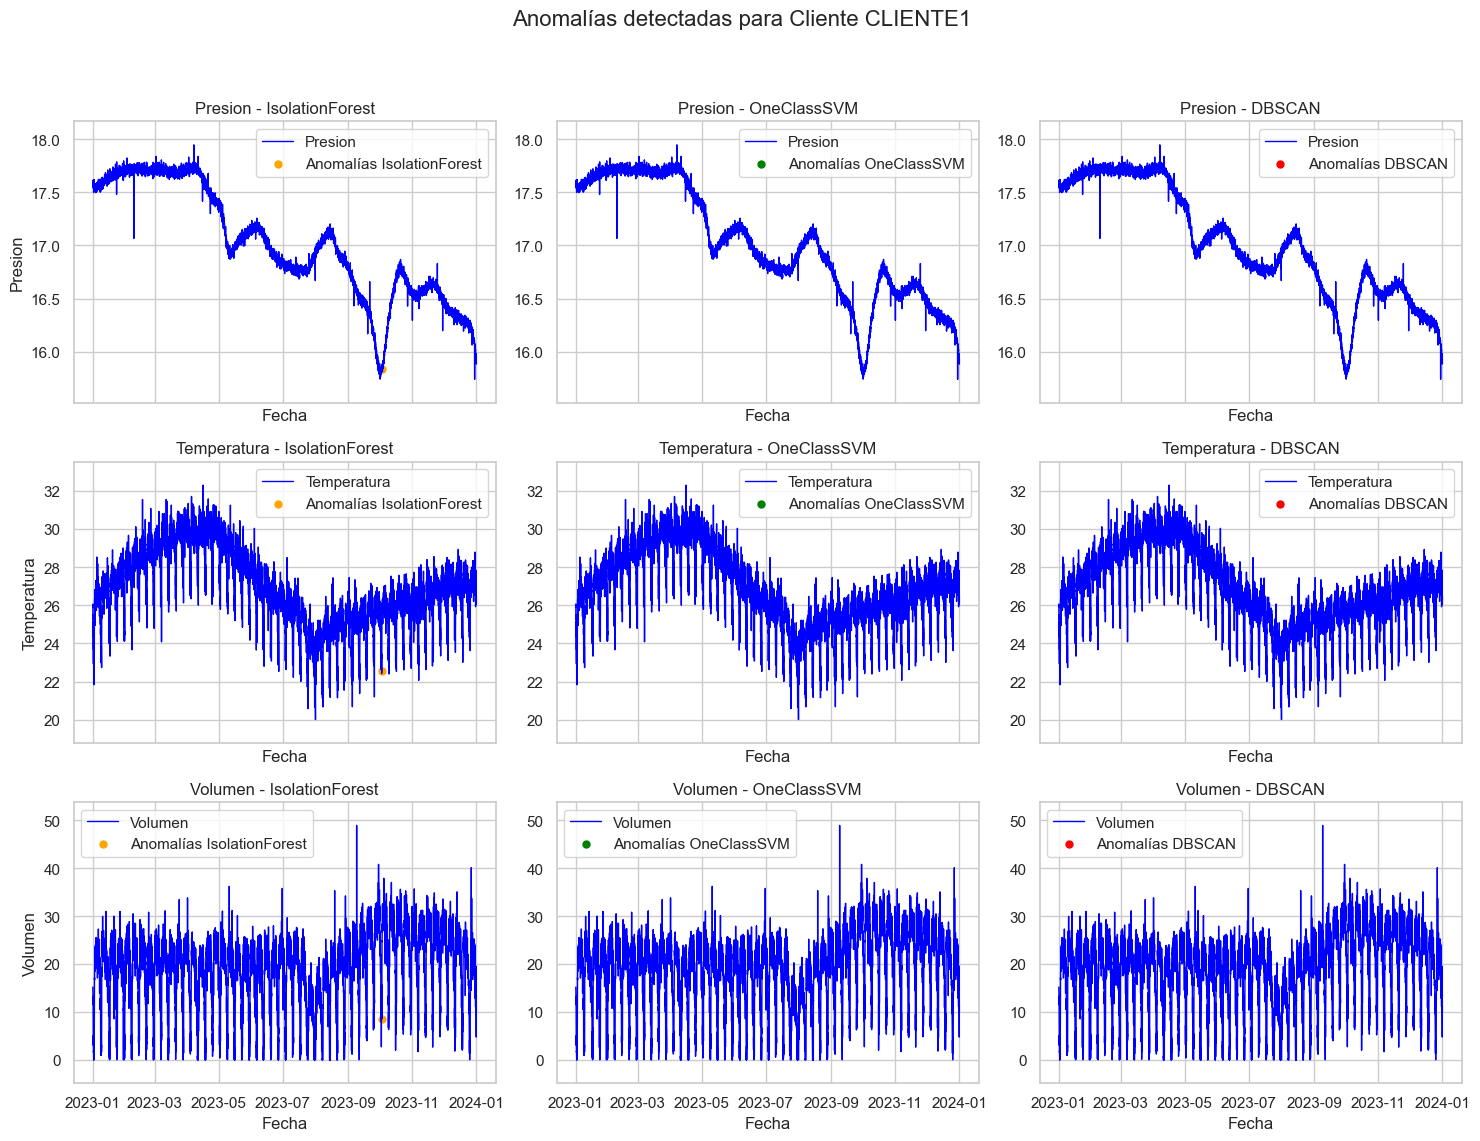

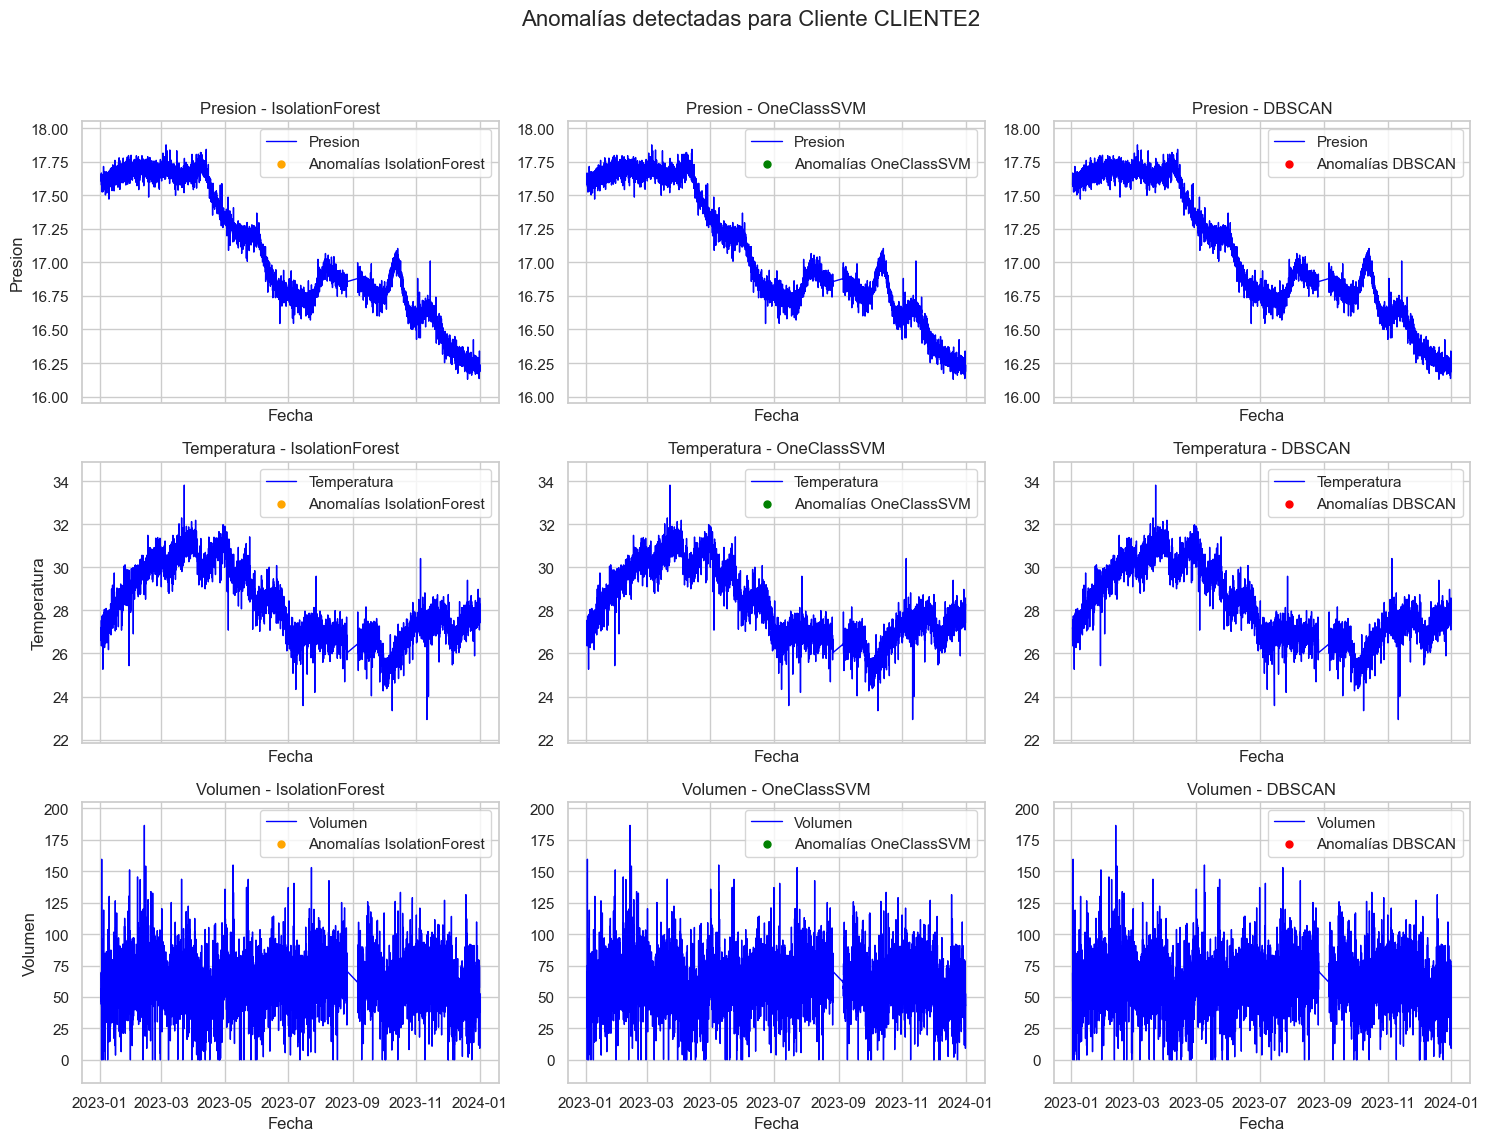

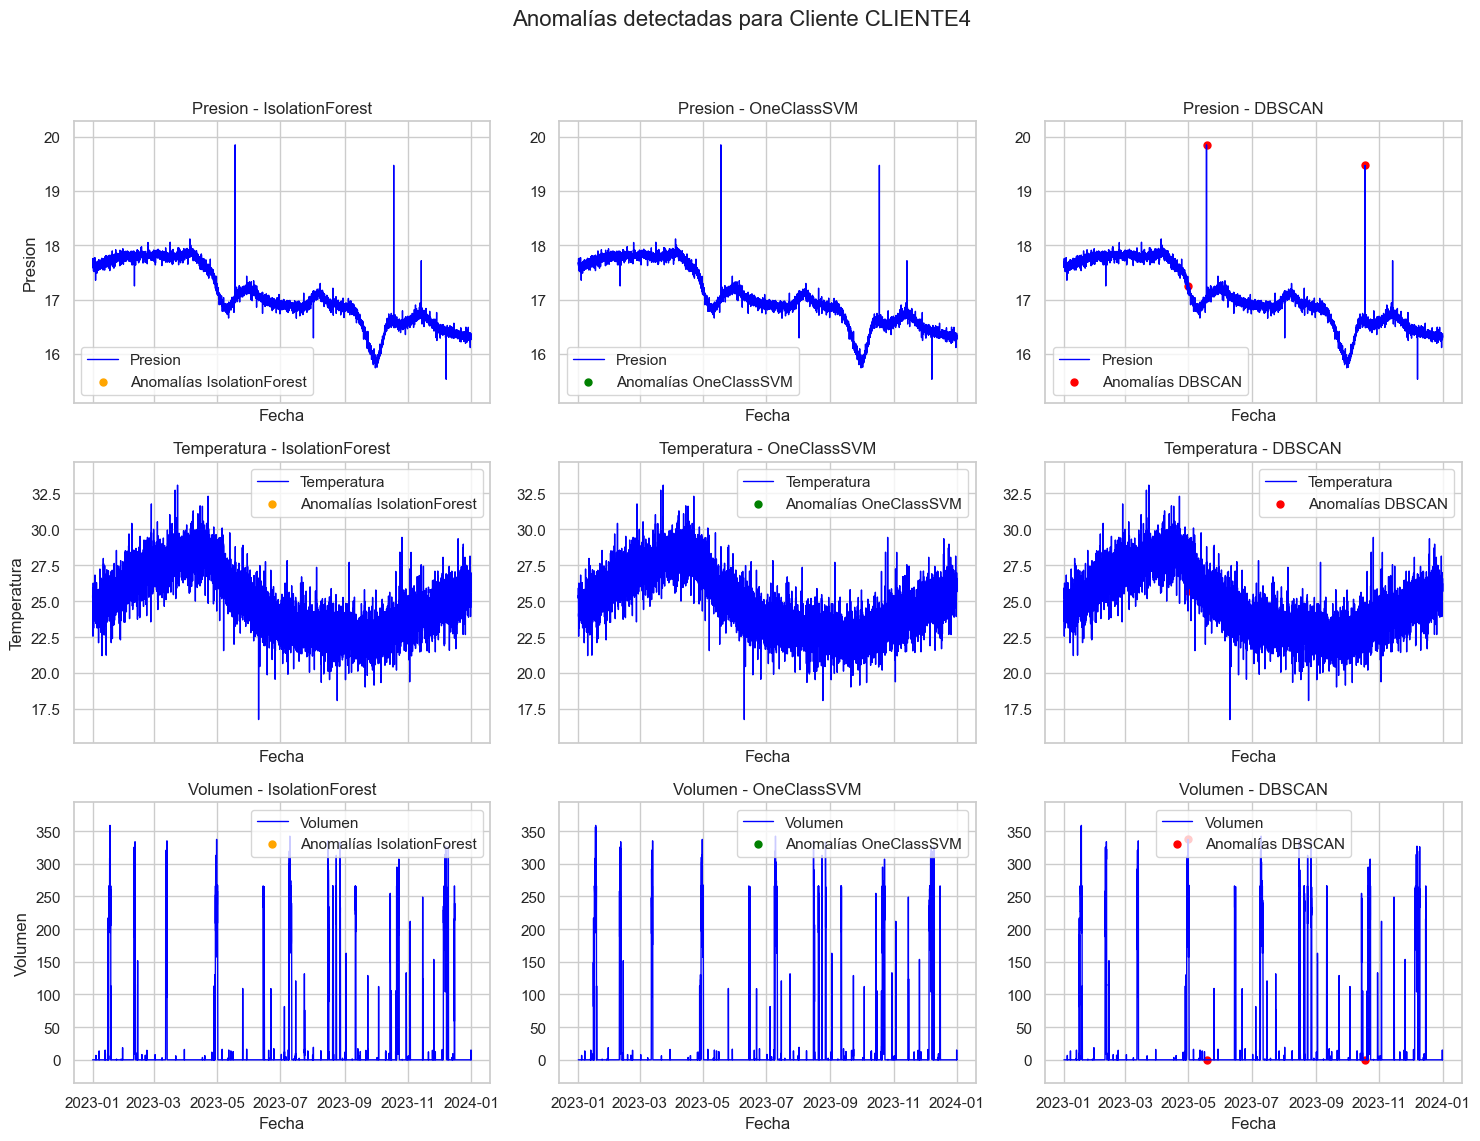

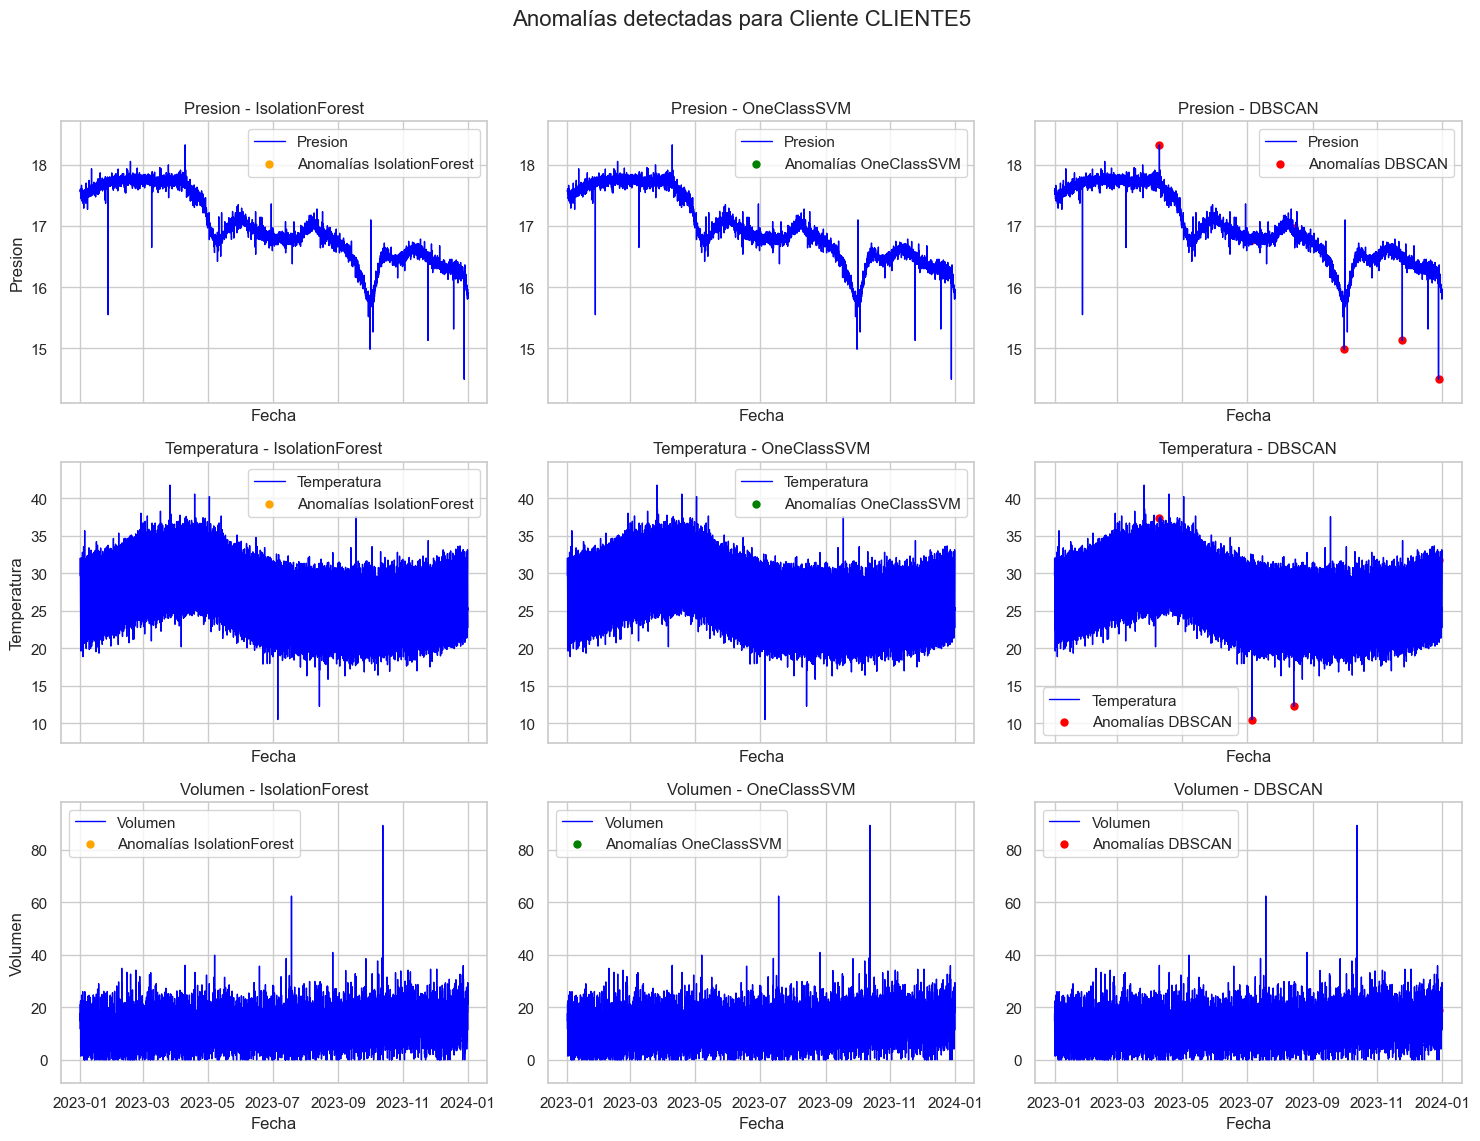

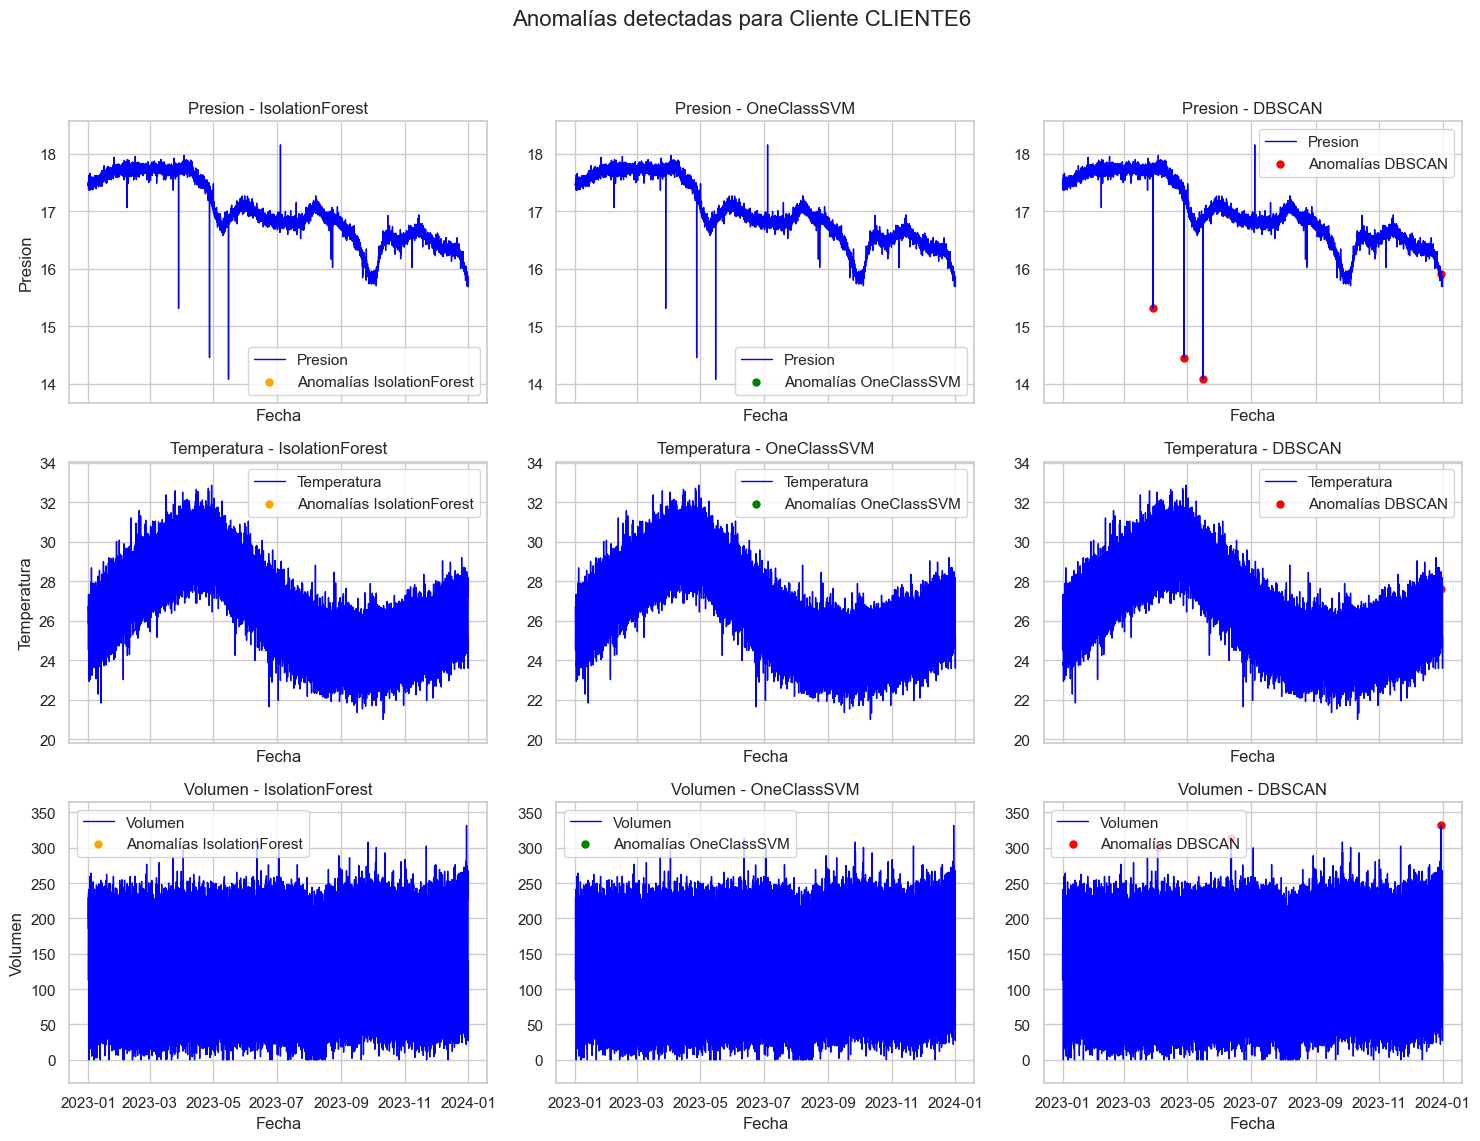

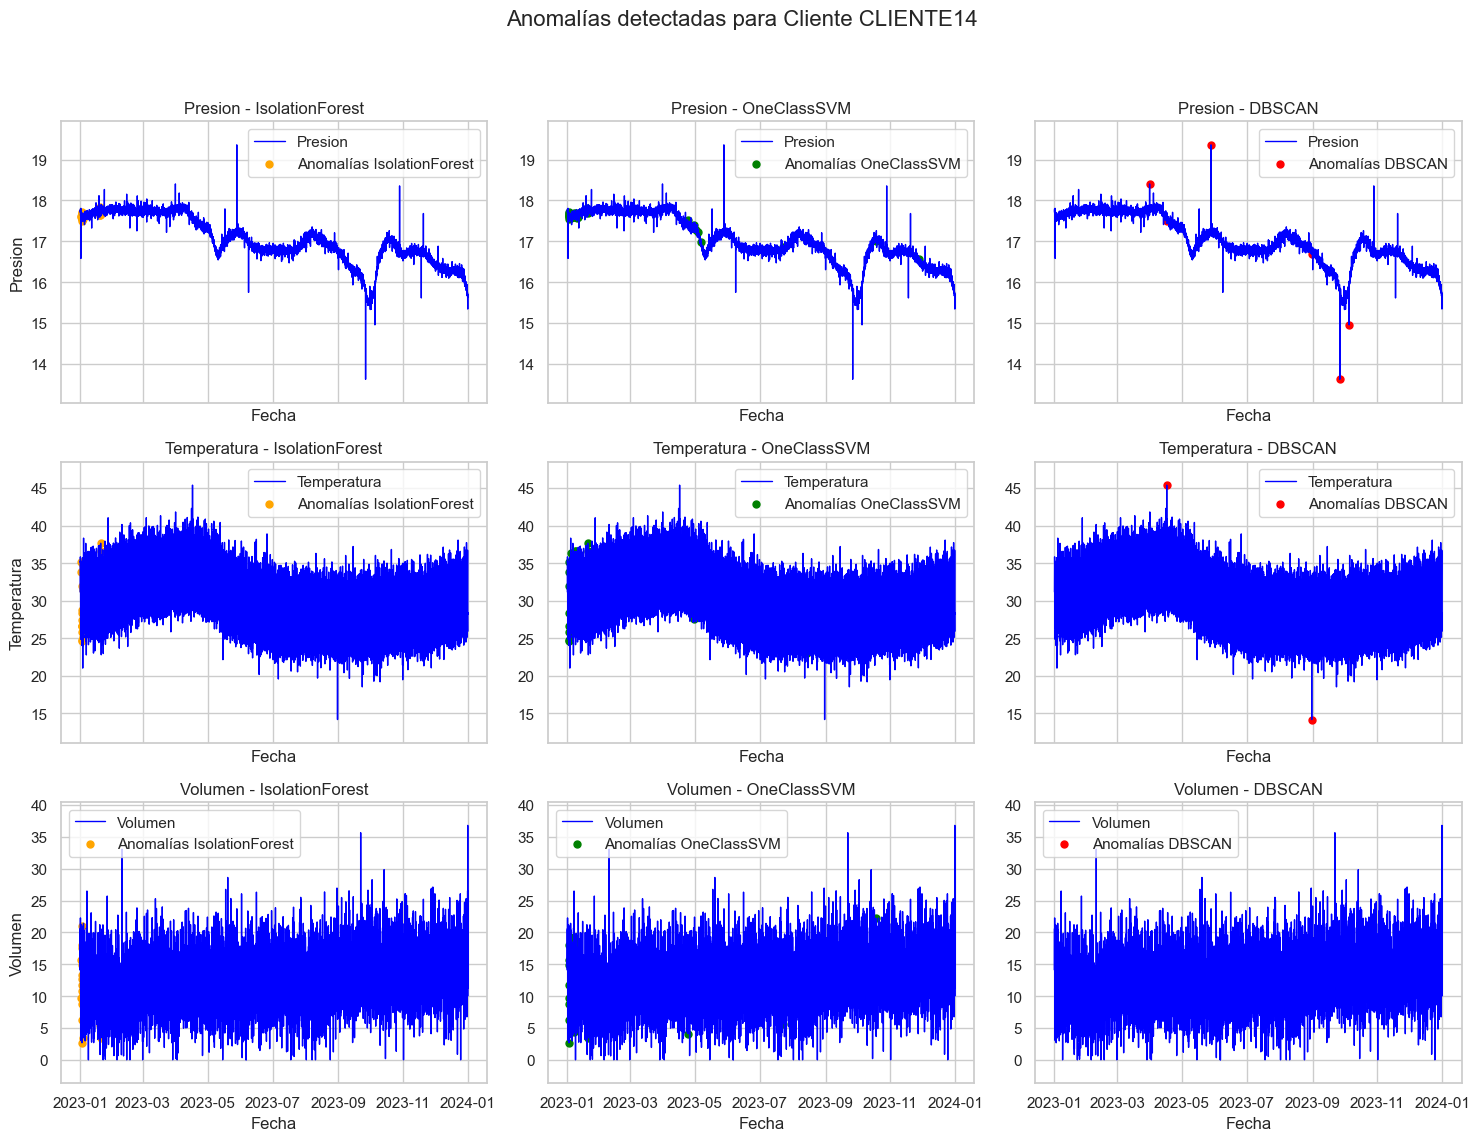

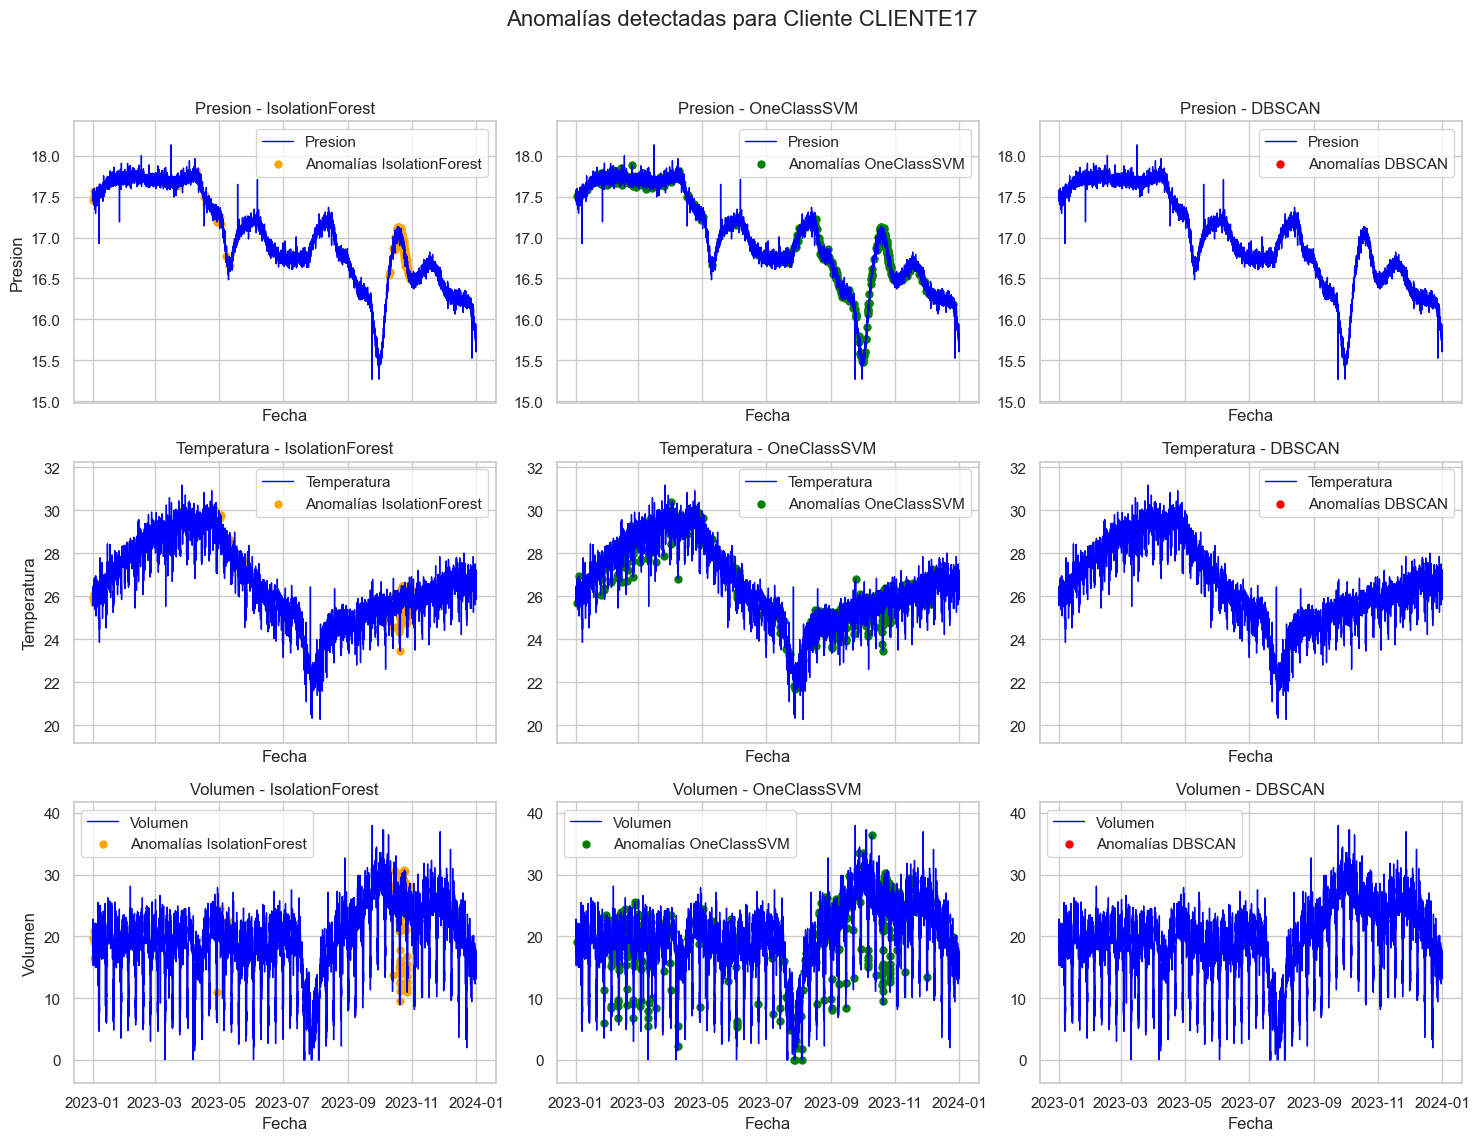

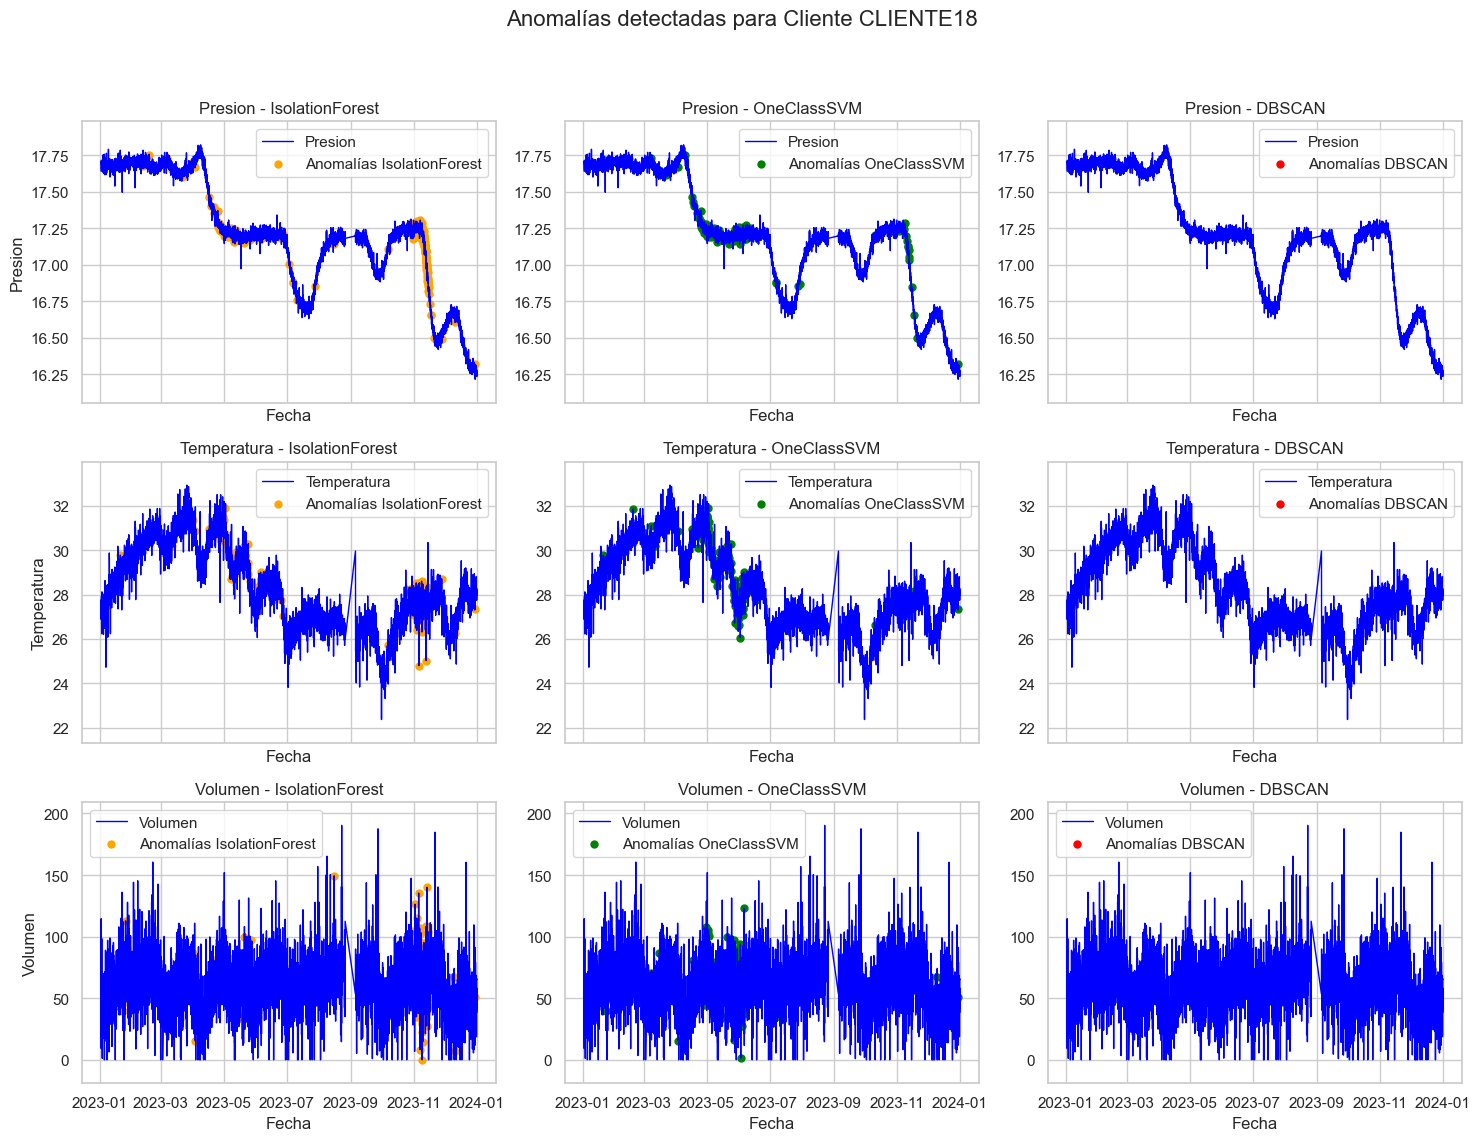

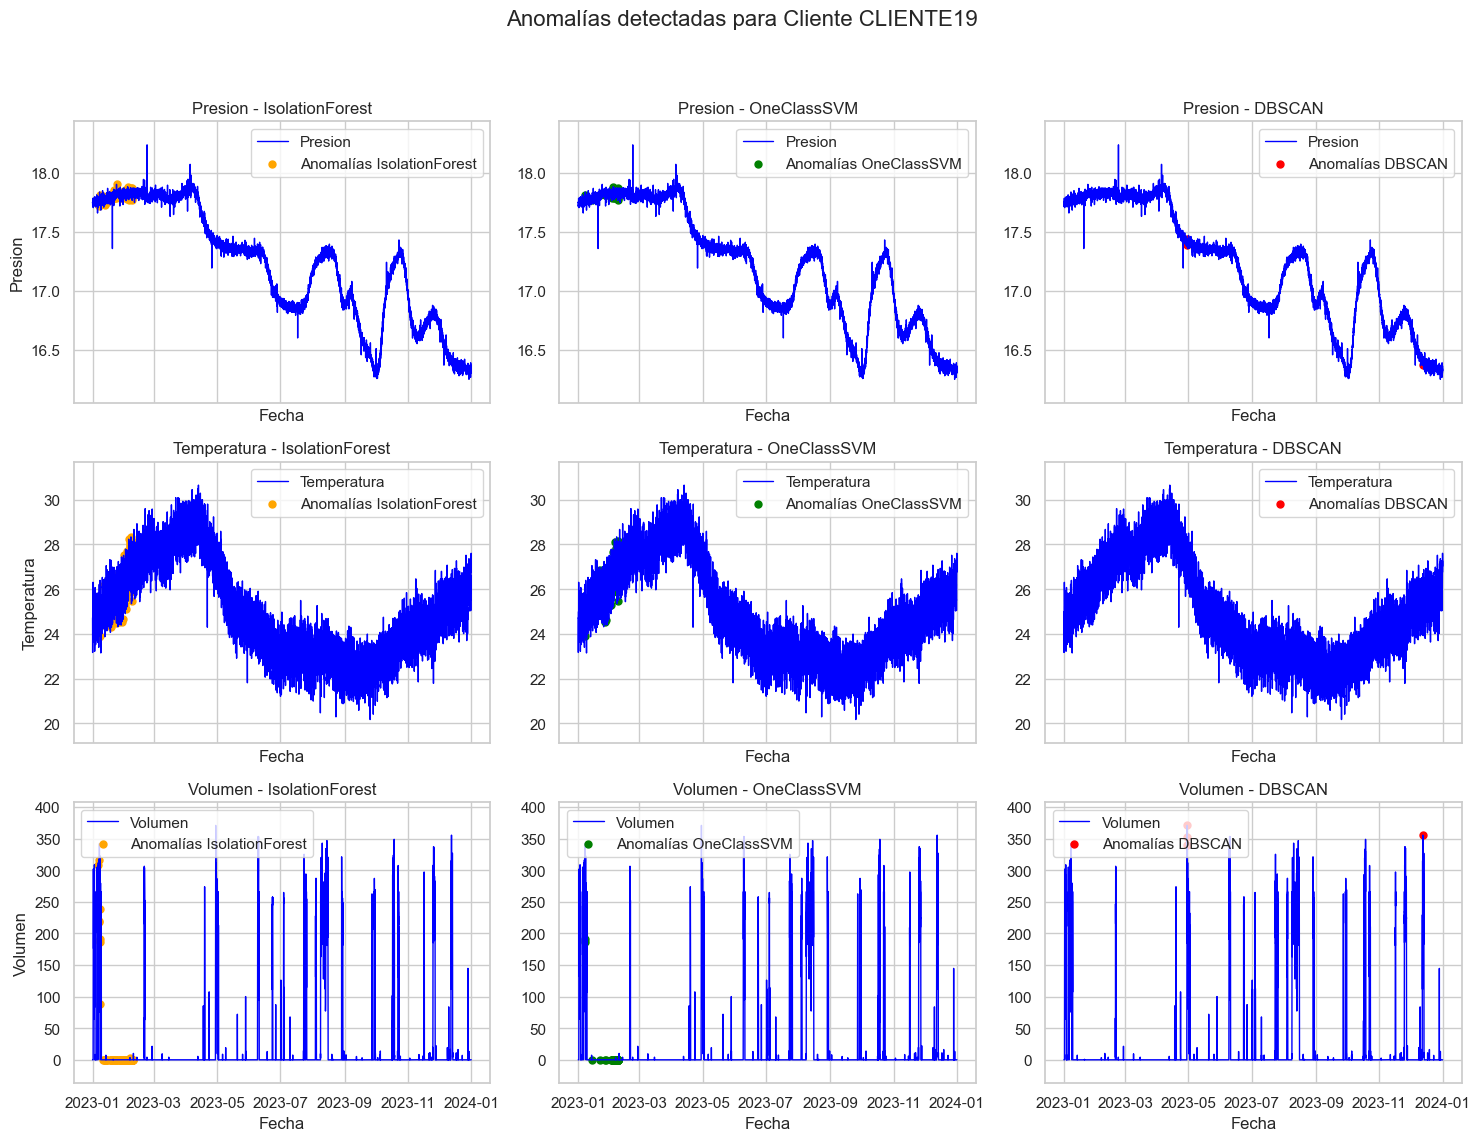

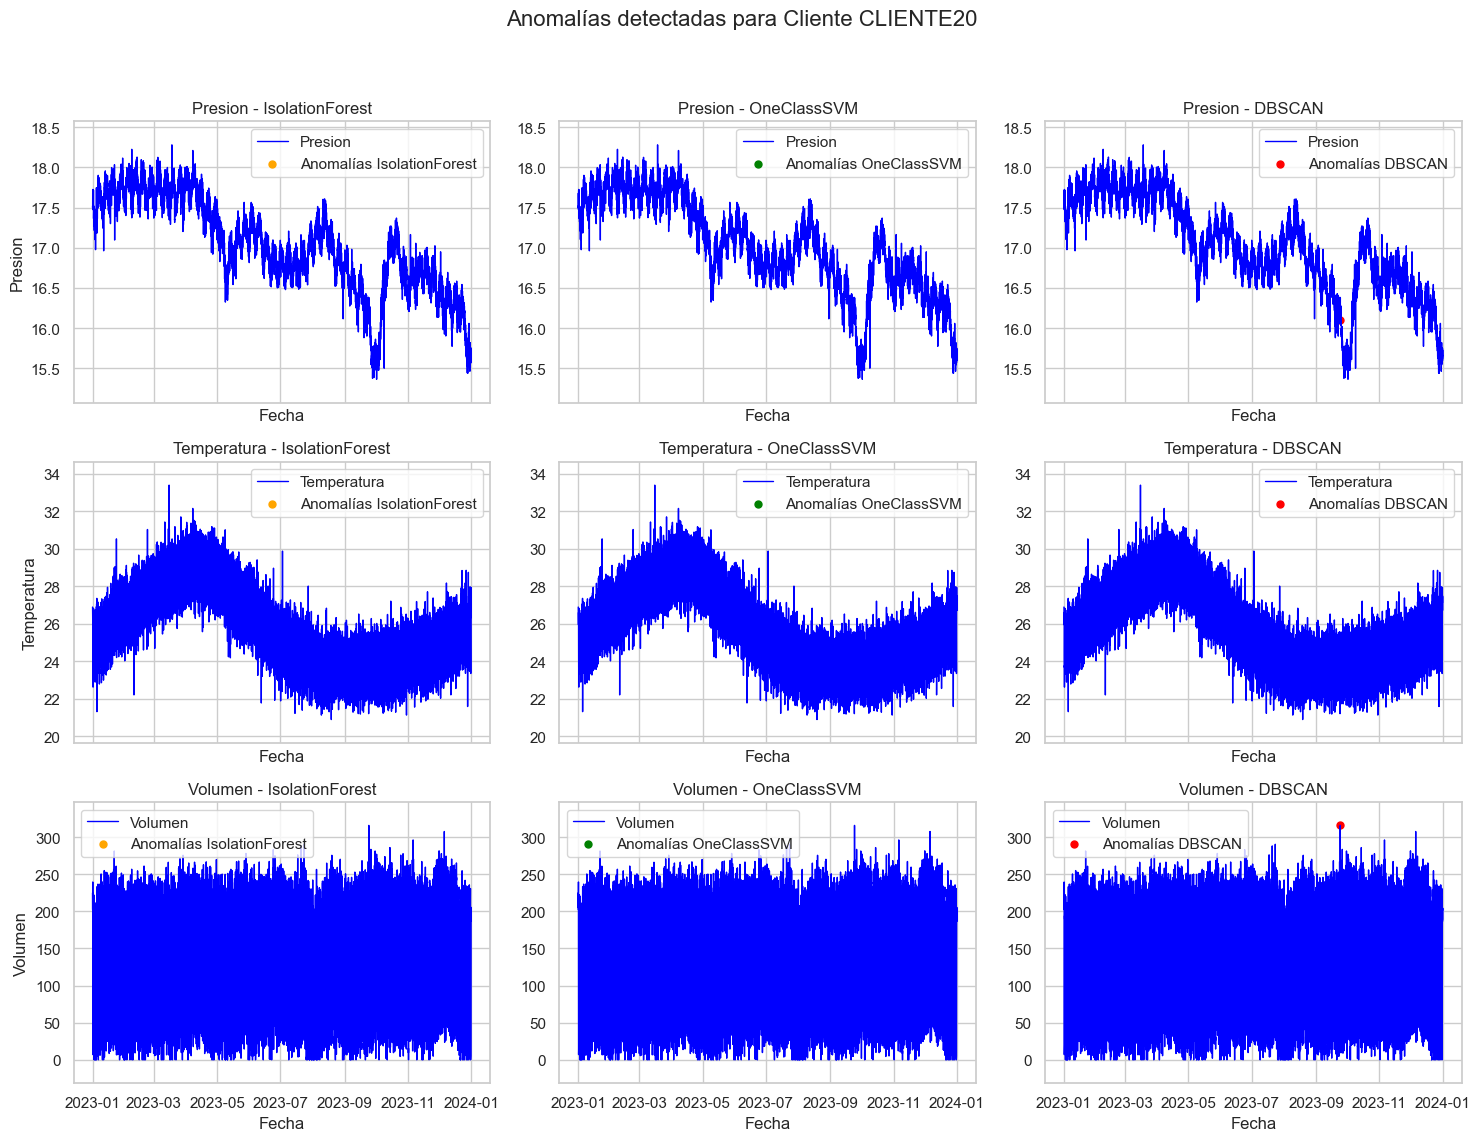

In [ ]:
# grupo1: caída en presión, grupo2: sin tendencia
graficar_anomalias_grupos(df_anomalias, grupo1)


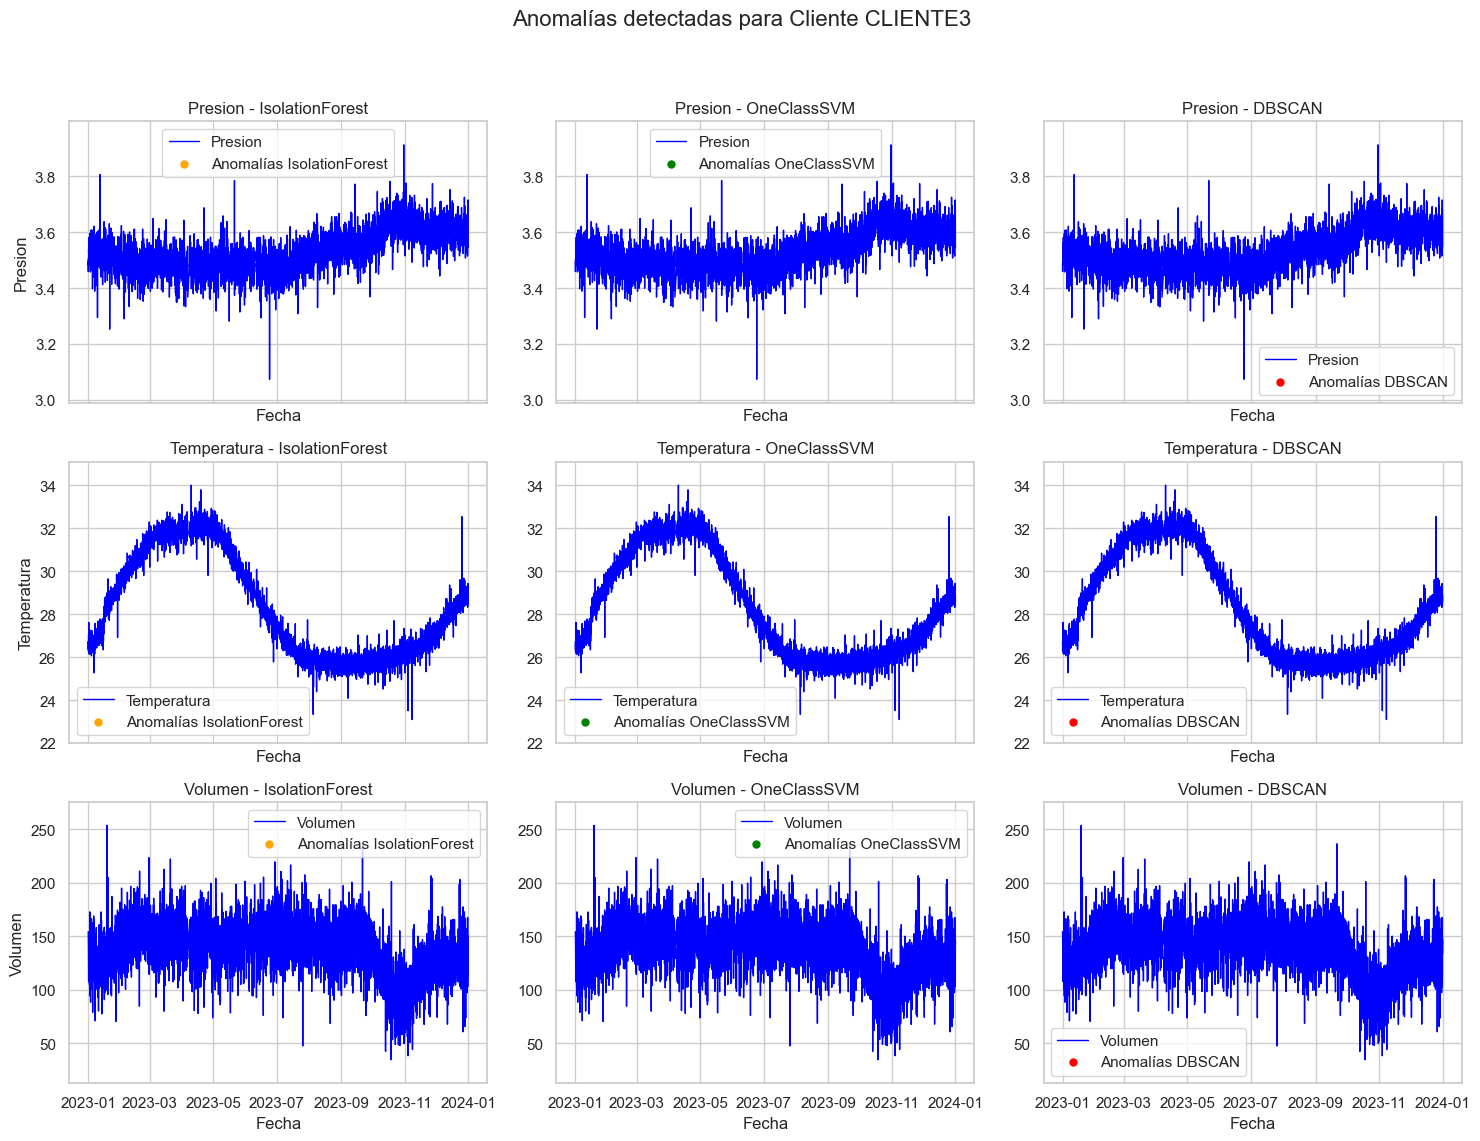

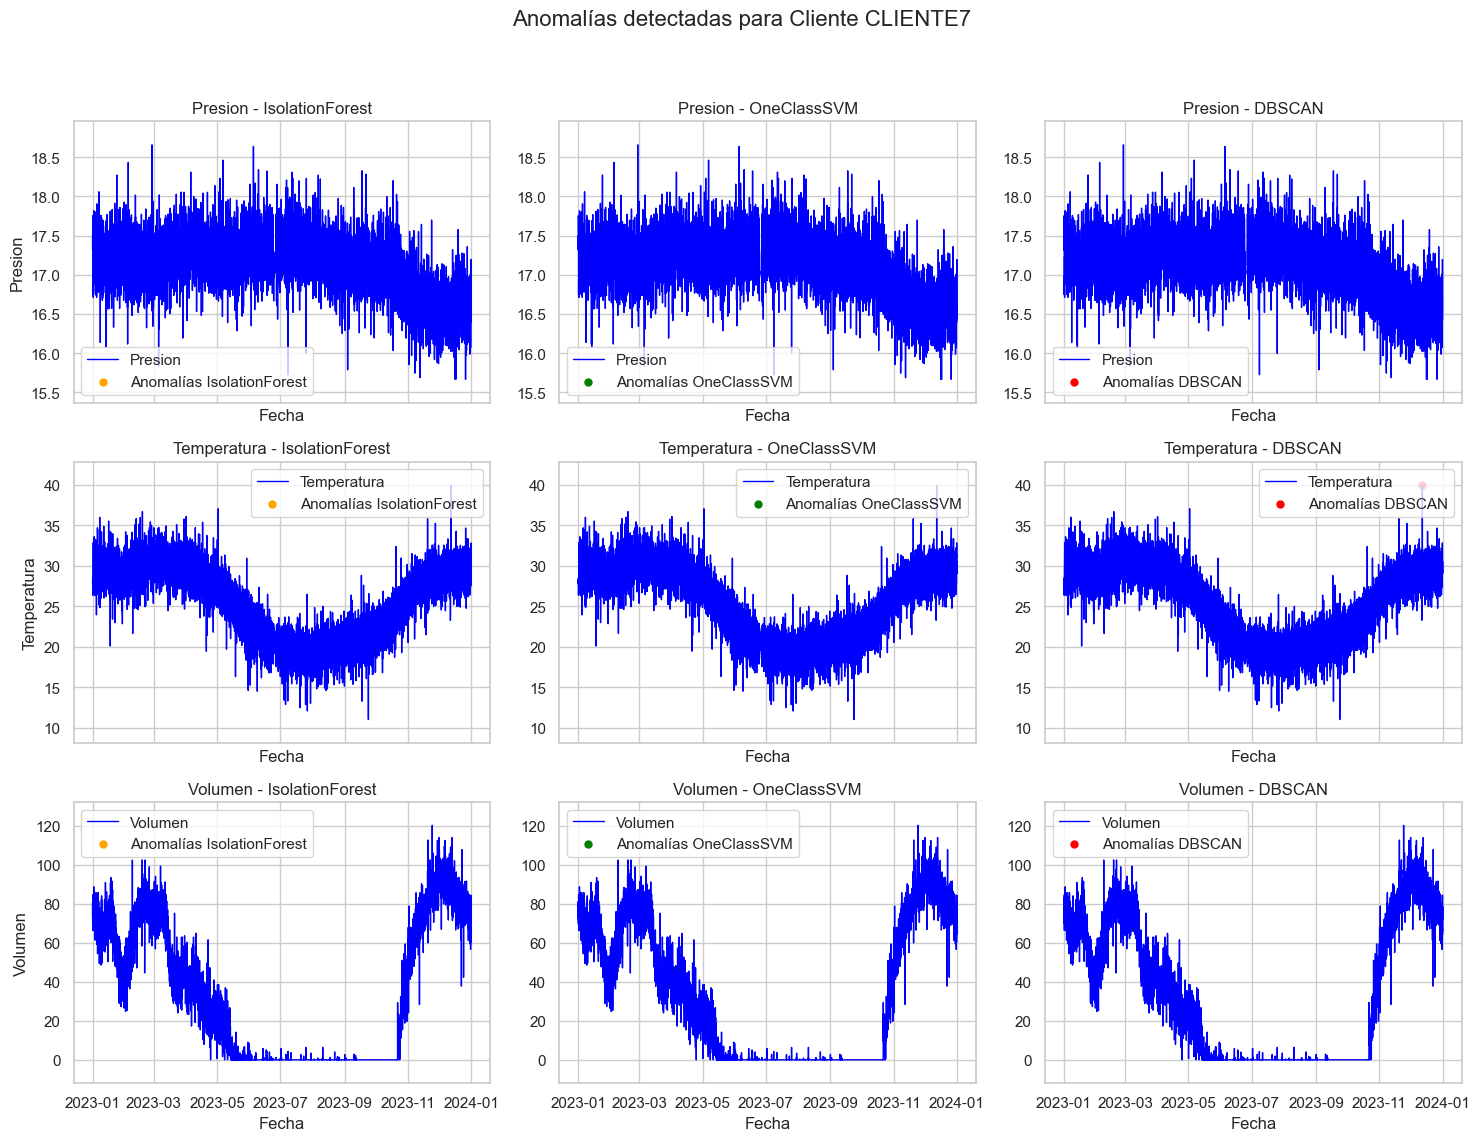

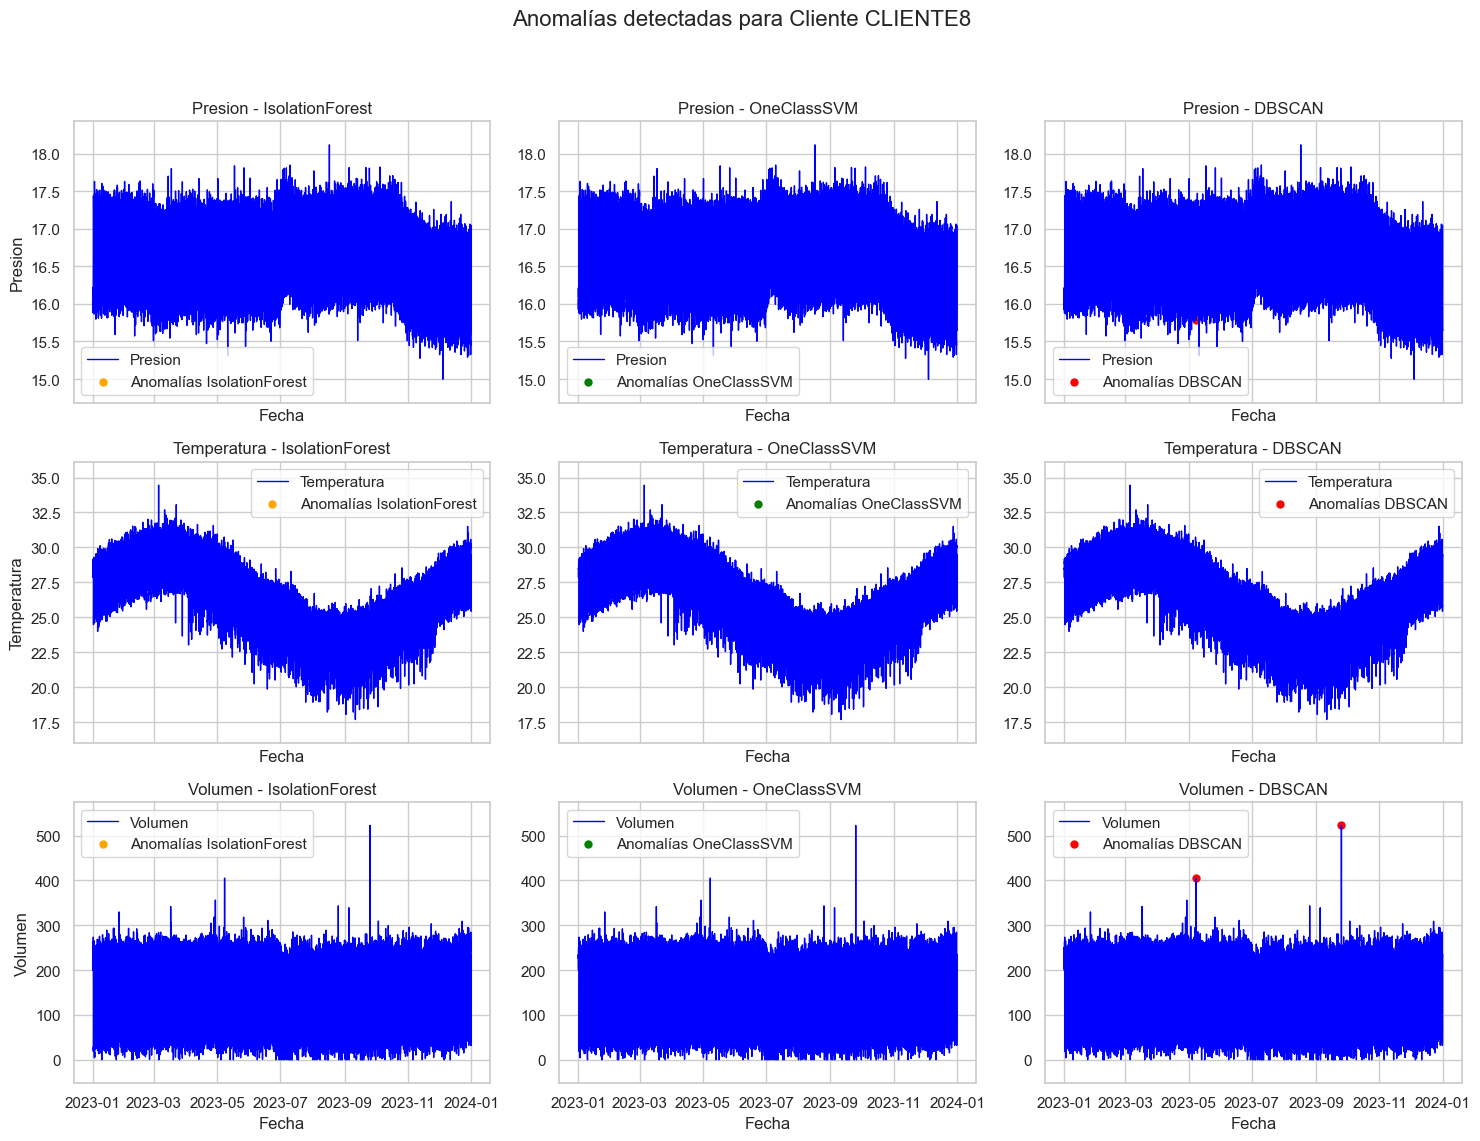

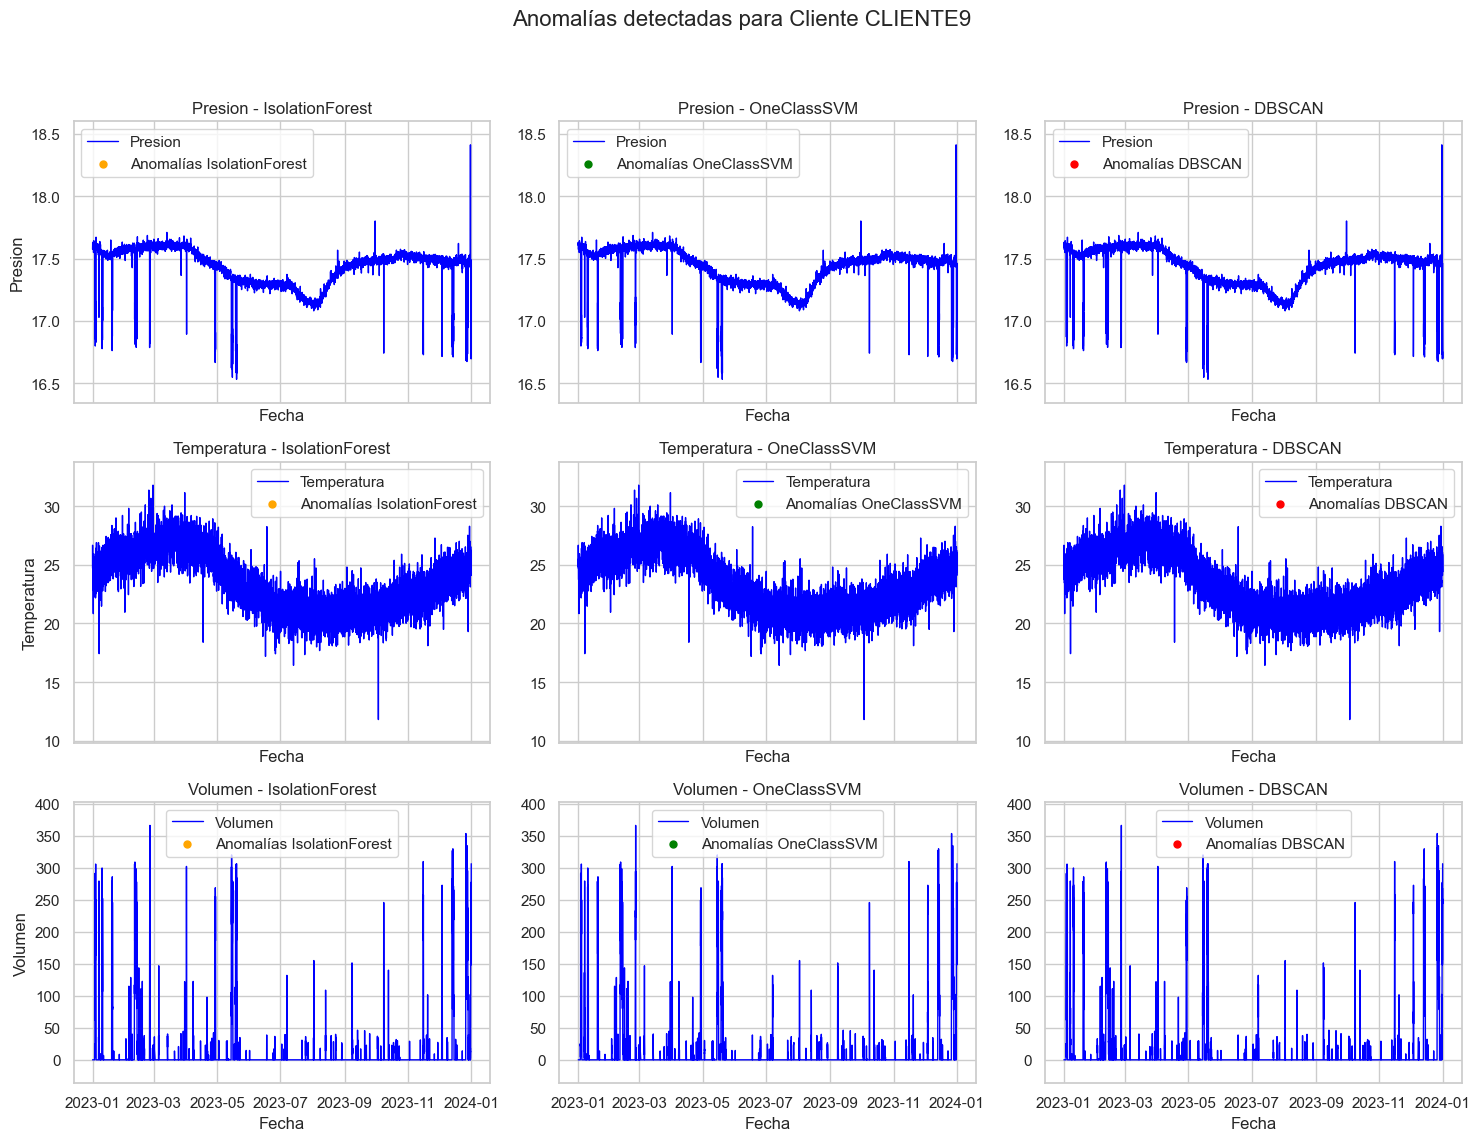

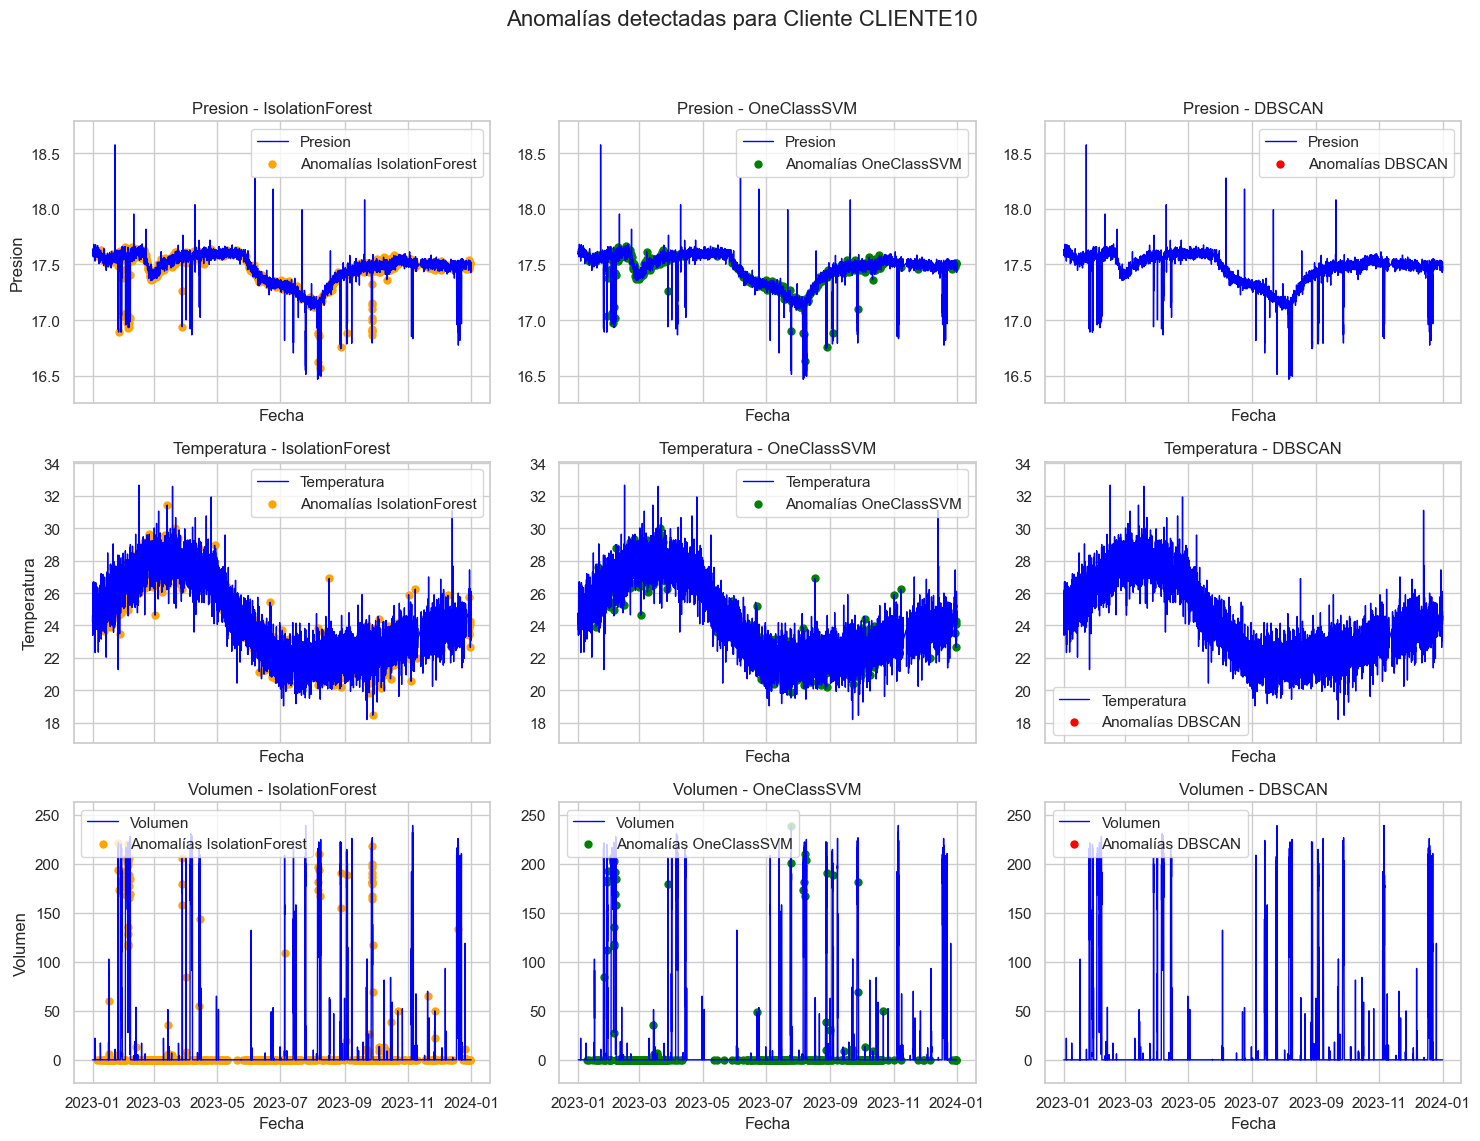

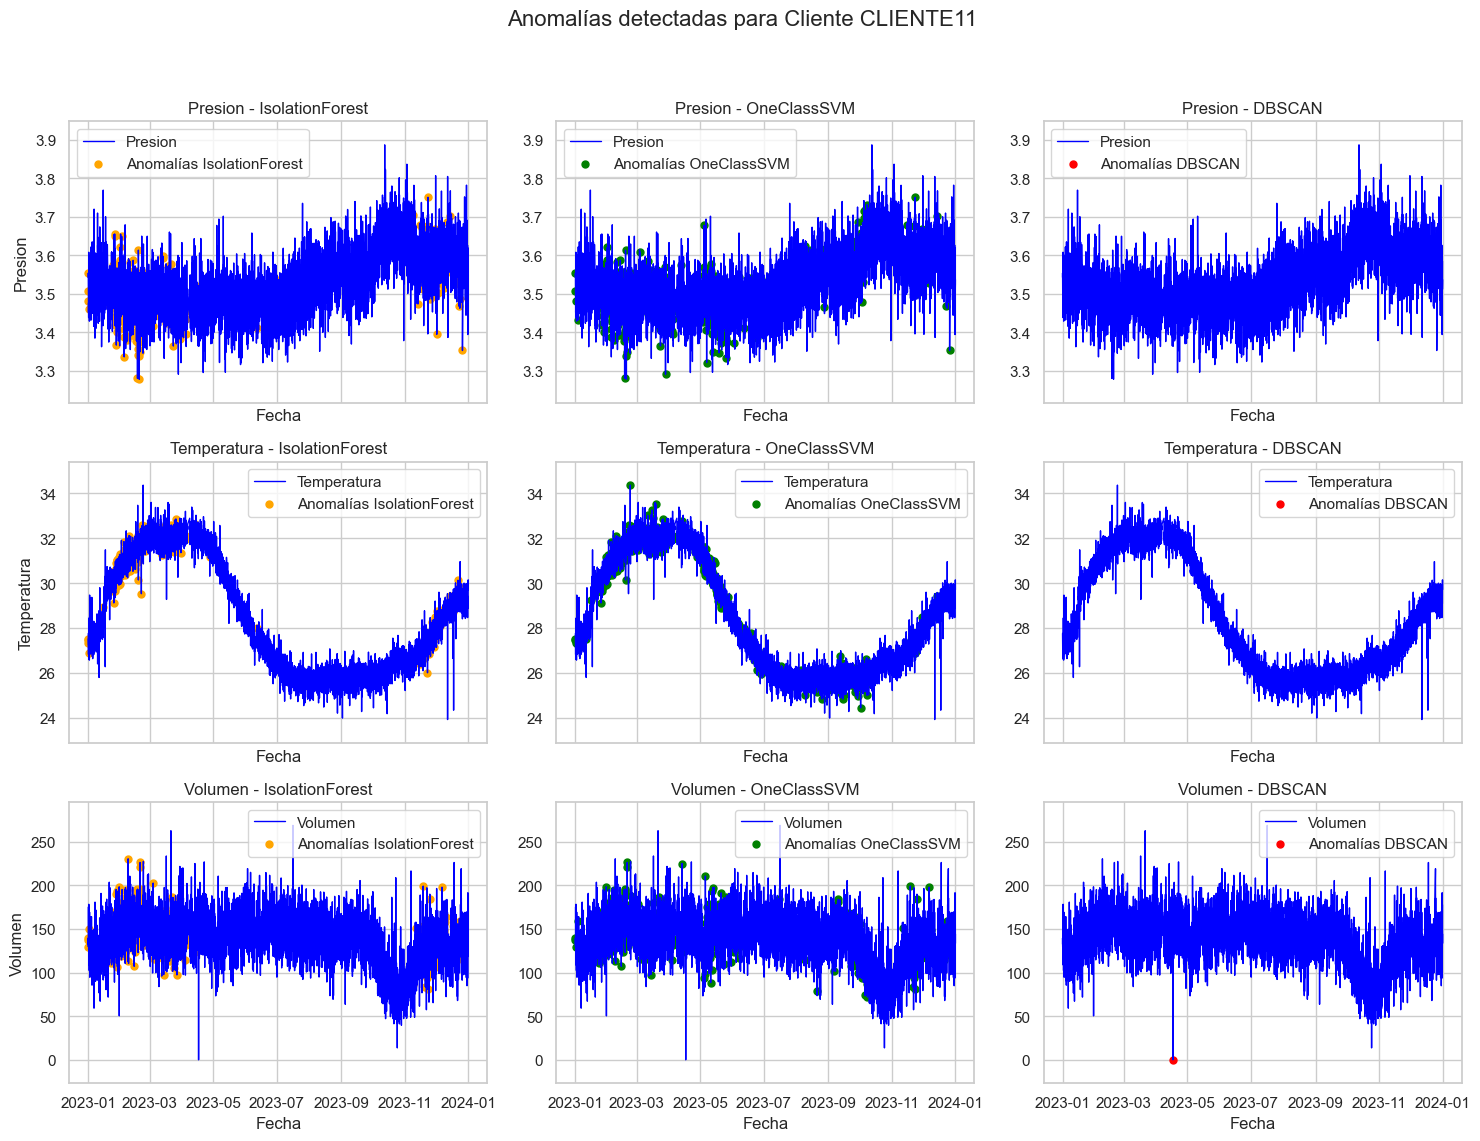

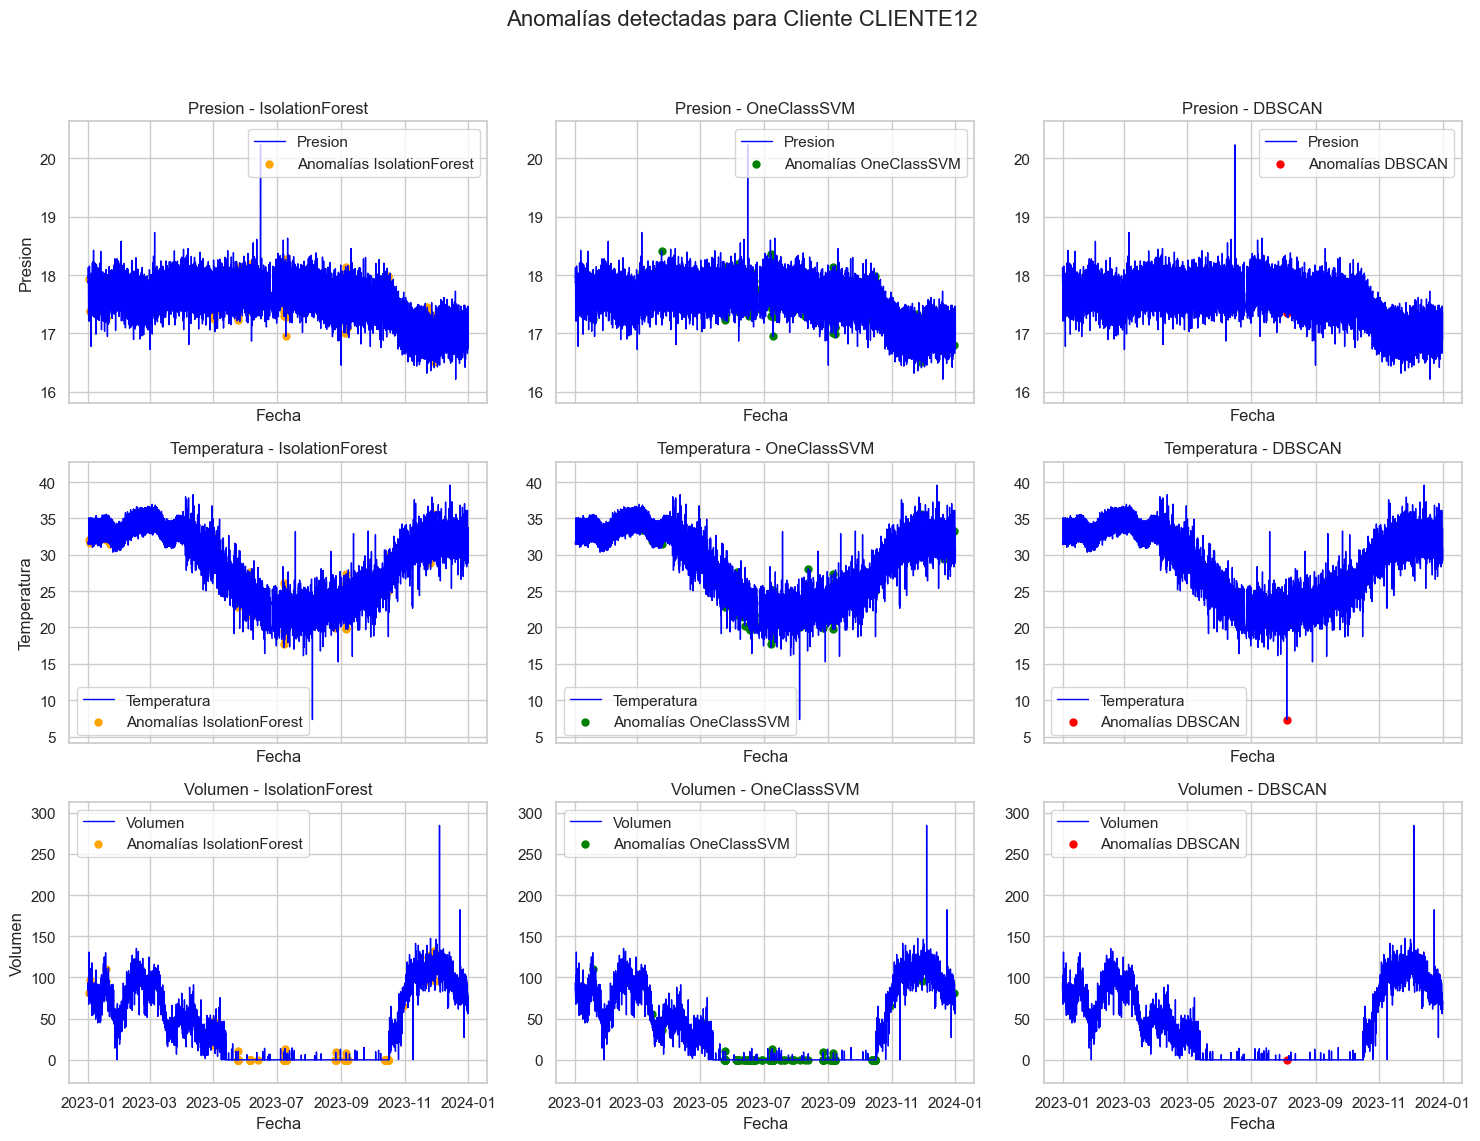

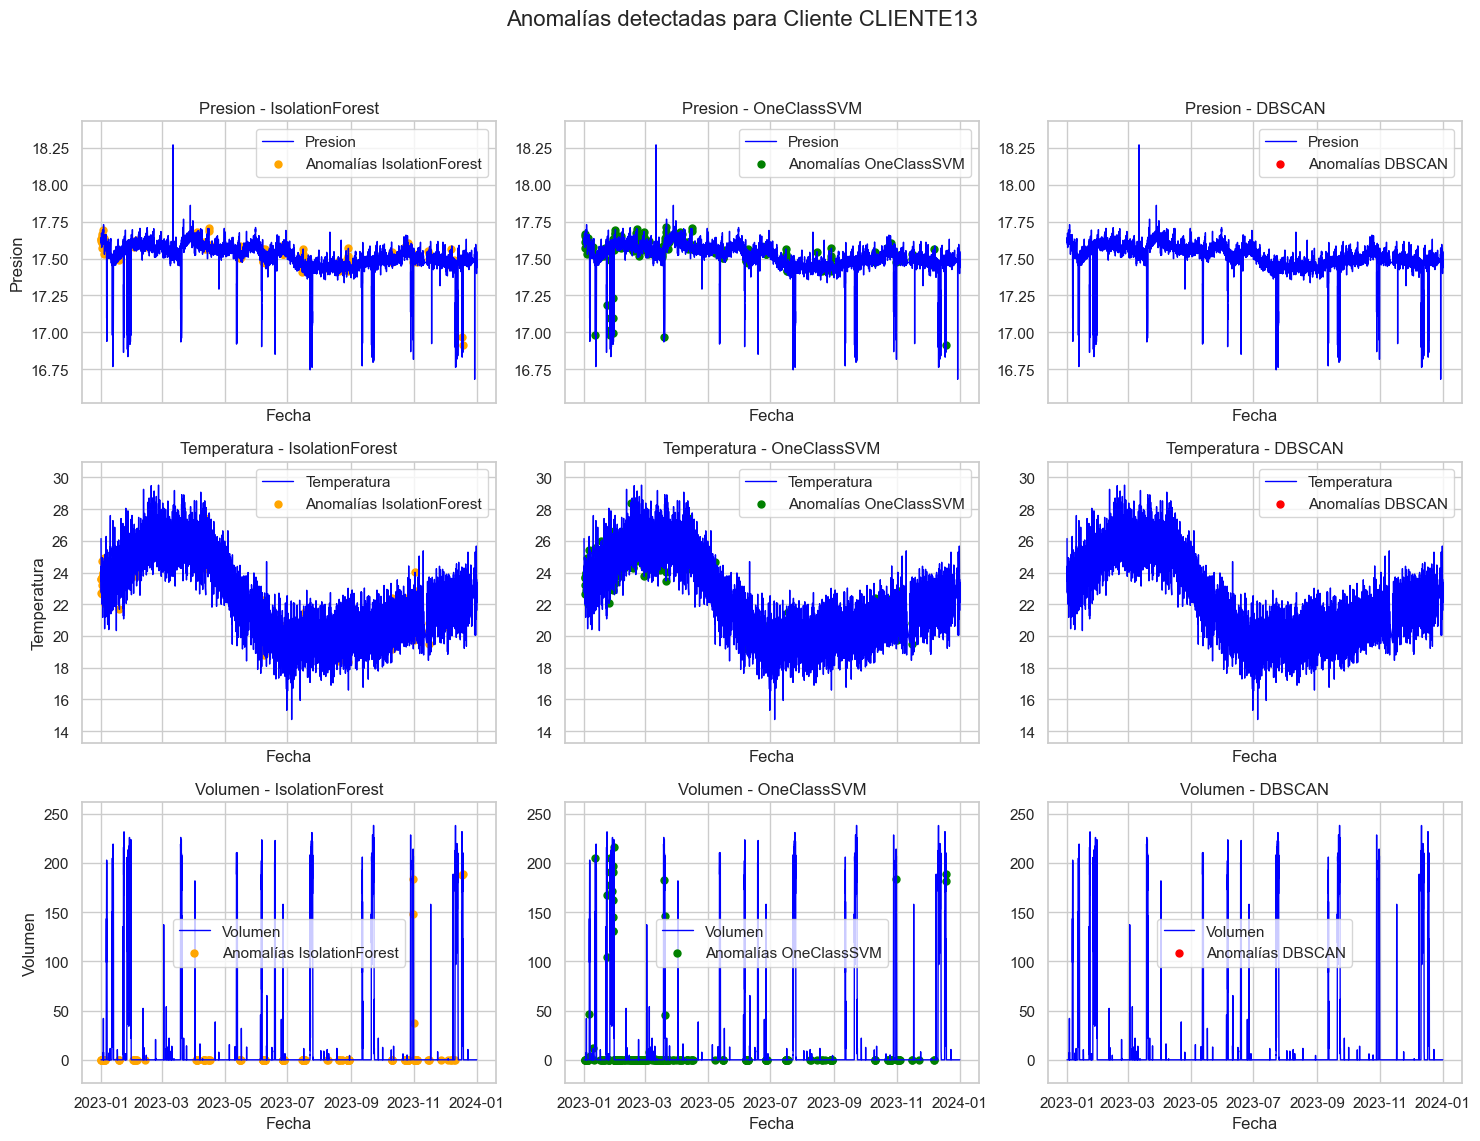

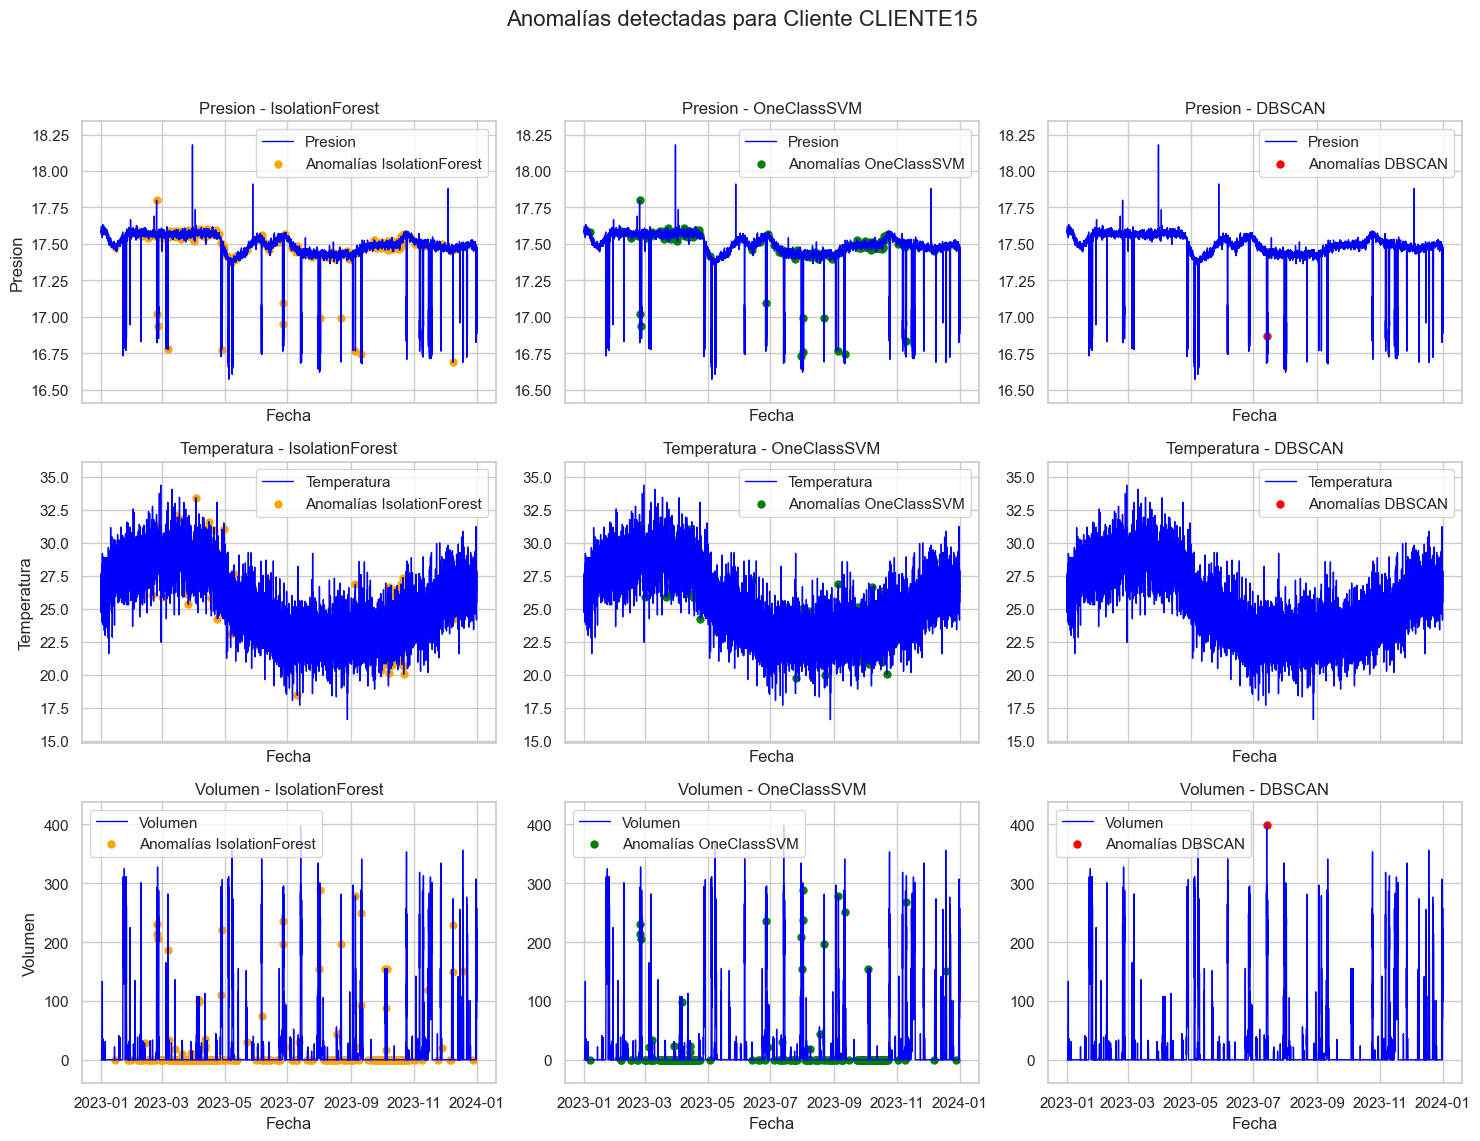

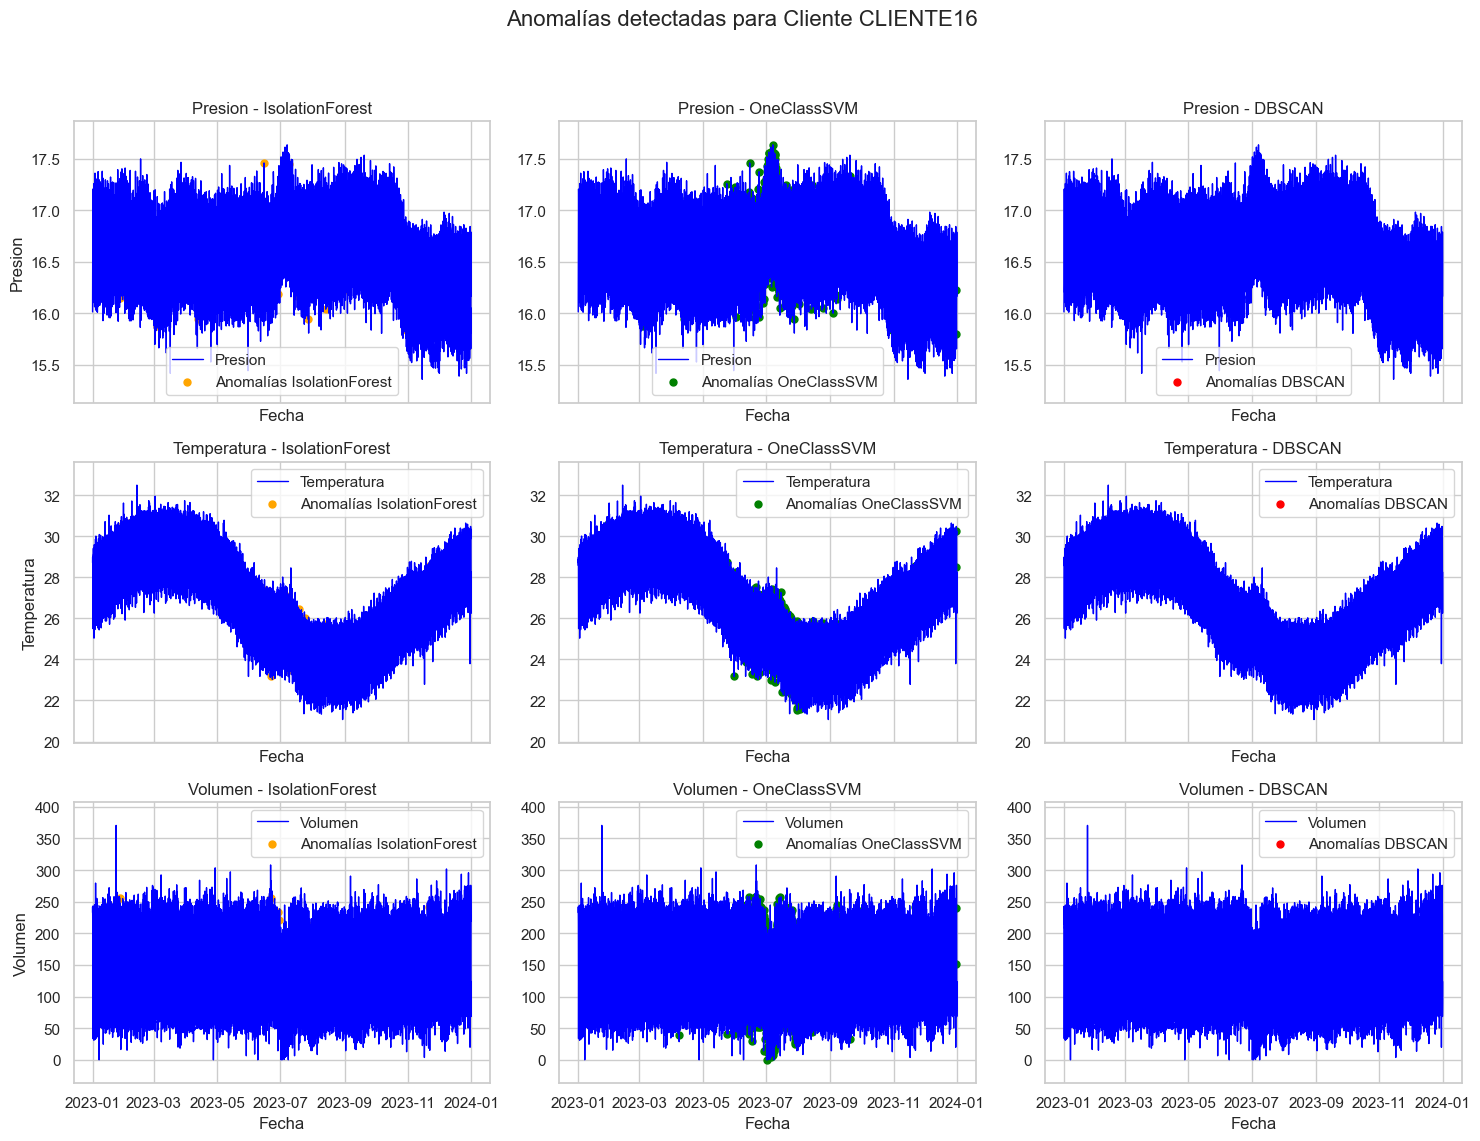

In [ ]:
# grupo1: caída en presión, grupo2: sin tendencia
graficar_anomalias_grupos(df_anomalias, grupo2)

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

def calcular_metricas_modelos(df_anomalias, grupo_clientes, nombre_grupo):
    df = df_anomalias.copy()
    resultados_metricas = []

    for cliente_id in grupo_clientes:
        df_cliente = df[df["cliente_id"] == cliente_id].dropna(subset=["presion", "temperatura", "volumen"])
        if df_cliente.empty:
            print(f"⚠️ Cliente {cliente_id} sin datos válidos.")
            continue

        # Variables para clustering
        features = df_cliente[["presion", "temperatura", "volumen"]].values

        # Modelos y sus etiquetas
        modelos_etiquetas = {
            "DBSCAN": df_cliente["anomalia_dbscan"].map({0: 1, 1: -1}).values,
            "IsolationForest": df_cliente["anomalia_iso"].map({0: 1, 1: -1}).values,
            "OneClassSVM": df_cliente["anomalia_svm"].map({0: 1, 1: -1}).values,
        }

        for modelo, labels in modelos_etiquetas.items():
            # Convertir etiquetas: -1 (anómalo) → 1, normal → 0
            etiquetas = np.array([1 if label == -1 else 0 for label in labels])

            # Verificar que haya al menos 2 clases
            if len(np.unique(etiquetas)) > 1:
                silhouette = silhouette_score(features, etiquetas)
                davies_bouldin = davies_bouldin_score(features, etiquetas)
            else:
                silhouette = np.nan
                davies_bouldin = np.nan

            resultados_metricas.append({
                "Grupo": nombre_grupo,
                "Cliente": cliente_id,
                "Modelo": modelo,
                "Silhouette": silhouette,
                "Davies-Bouldin": davies_bouldin
            })

    return resultados_metricas


In [ ]:
# Calcular para grupo1 y grupo2  # grupo1: caída en presión, grupo2: sin tendencia
print("Calculando métricas para grupo1 (caída en presión apartir del 2023)...")
metricas_grupo1 = calcular_metricas_modelos(df_anomalias, grupo1, "grupo1")
df_metricas_grupo1 = pd.DataFrame(metricas_grupo1)
print(df_metricas_grupo1)
print(" ")

print("Calculando métricas para grupo2 (sin tendencia)...")
metricas_grupo2 = calcular_metricas_modelos(df_anomalias, grupo2, "grupo2")
df_metricas_grupo2 = pd.DataFrame(metricas_grupo2)
print(df_metricas_grupo2)
print(" ")

# Combinar resultados en un solo DataFrame
df_metricas = pd.DataFrame(metricas_grupo1 + metricas_grupo2)


Calculando métricas para grupo1 (caída en presión apartir del 2023)...
     Grupo    Cliente           Modelo  Silhouette  Davies-Bouldin
0   grupo1   CLIENTE1           DBSCAN         NaN             NaN
1   grupo1   CLIENTE1  IsolationForest    0.216198        0.581625
2   grupo1   CLIENTE1      OneClassSVM         NaN             NaN
3   grupo1   CLIENTE2           DBSCAN         NaN             NaN
4   grupo1   CLIENTE2  IsolationForest         NaN             NaN
5   grupo1   CLIENTE2      OneClassSVM         NaN             NaN
6   grupo1   CLIENTE4           DBSCAN    0.792241        1.798818
7   grupo1   CLIENTE4  IsolationForest         NaN             NaN
8   grupo1   CLIENTE4      OneClassSVM         NaN             NaN
9   grupo1   CLIENTE5           DBSCAN    0.235363        4.975836
10  grupo1   CLIENTE5  IsolationForest         NaN             NaN
11  grupo1   CLIENTE5      OneClassSVM         NaN             NaN
12  grupo1   CLIENTE6           DBSCAN    0.034061        

In [ ]:
# Unir métricas de ambos grupos si no lo has hecho
metricas_grupo1 = calcular_metricas_modelos(df_anomalias, grupo1, "grupo1")
metricas_grupo2 = calcular_metricas_modelos(df_anomalias, grupo2, "grupo2")
df_metricas_total = pd.DataFrame(metricas_grupo1 + metricas_grupo2)

# Agrupar por Grupo y Modelo
resumen_grupo = df_metricas_total.groupby(['Grupo', 'Modelo'])[['Silhouette', 'Davies-Bouldin']].mean().reset_index()

# Mostrar
print("Métricas promedio por grupo y modelo:")
print(resumen_grupo.to_string(index=False))


🔍 Métricas promedio por grupo y modelo:
 Grupo          Modelo  Silhouette  Davies-Bouldin
grupo1          DBSCAN    0.414114        3.359001
grupo1 IsolationForest   -0.024926        3.886872
grupo1     OneClassSVM   -0.137947        7.596496
grupo2          DBSCAN    0.468622        0.422146
grupo2 IsolationForest   -0.176863       17.188708
grupo2     OneClassSVM   -0.038846       13.950621


DBSCAN es el mejor modelo en ambos grupos:
En grupo2 tiene un Silhouette alto (~0.47) y Davies-Bouldin bajo (~0.42) → indica clústeres bien definidos.
En grupo1, aunque no es tan bueno como en grupo2, supera a los otros modelos.

Isolation Forest y One-Class SVM tienen:
Silhouette negativos, lo que indica que muchos puntos estarían mejor asignados a otros clústeres.
Davies-Bouldin > 3–17, lo que sugiere solapamiento fuerte y dispersión.

Los resultados difieren entre grupos, lo que puede explicarse por:
Naturaleza distinta de los patrones de comportamiento (caída en presión vs sin tendencia).
Parámetros no ajustados de forma específica para cada cliente o grupo.

***
Grupos mediante segmetnacion

In [ ]:
DB_PATH = "../db/optigas.db"
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM gold_lecturas_completas", conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
conn.close()

df.head()

timestamp    presion  temperatura    volumen cliente_id
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751   CLIENTE1
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739   CLIENTE1
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914   CLIENTE1
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299   CLIENTE1
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626   CLIENTE1

c:\Users\johan\.conda\envs\optigas\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\johan\.conda\envs\optigas\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\johan\.conda\envs\optigas\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\johan\.conda\envs\optigas\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\johan\.conda\envs\optigas\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(ex

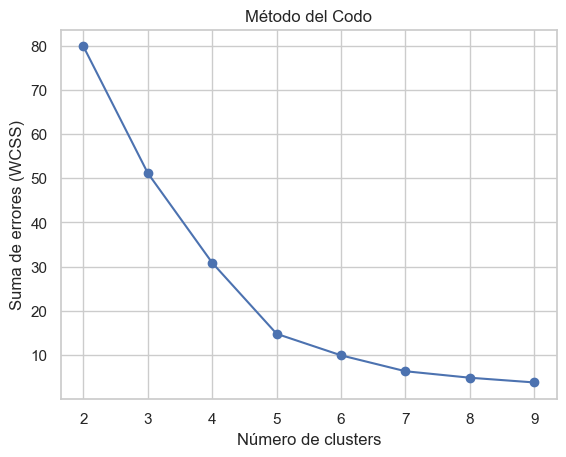

In [ ]:
# Calcular características agregadas por cliente
agg_df = df.groupby("cliente_id").agg(
    consumo_promedio=('volumen', 'mean'),
    consumo_std=('volumen', 'std'),
    consumo_max=('volumen', 'max'),
    consumo_min=('volumen', 'min'),
    dias_actividad=('timestamp', 'nunique'),
    temp_prom=('temperatura', 'mean'),
    presion_prom=('presion', 'mean')
).dropna()

# Paso previo antes de normalizar
columnas_originales = agg_df.columns.tolist()

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg_df)

# Identificar numero de clusters óptimo usando el método del codo
wcss = []  # Within-cluster sum of squares
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Suma de errores (WCSS)')
plt.title('Método del Codo')
plt.grid(True)
plt.show()


In [ ]:
# Clustering
k_optimo = 5  
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
labels = kmeans.fit_predict(X_scaled)

agg_df['cluster'] = labels


c:\Users\johan\.conda\envs\optigas\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
agg_df.head()  # Mostrar las primeras filas del DataFrame con los clusters asignados

consumo_promedio  consumo_std  consumo_max  consumo_min  \
cliente_id                                                            
CLIENTE1           19.976401     7.939171    65.936644          0.0   
CLIENTE10          11.788209    43.991880   247.072990          0.0   
CLIENTE11         131.649378    34.225553   298.259573          0.0   
CLIENTE12          33.731496    41.952033   284.475087          0.0   
CLIENTE13          10.276088    41.184079   253.867916          0.0   

            dias_actividad  temp_prom  presion_prom  cluster  
cliente_id                                                    
CLIENTE1             43412  25.575853     17.535934        2  
CLIENTE10            41059  23.500489     17.473694        1  
CLIENTE11            42247  26.307099      3.545513        3  
CLIENTE12            41776  26.689551     17.833667        4  
CLIENTE13            41059  21.591365     17.492521        1

In [ ]:
# Mostrar la composición de cada cluster
for cluster_id, clientes in agg_df.groupby('cluster').groups.items():
    print(f"Cluster {cluster_id}: {list(clientes)}")

Cluster 0: ['CLIENTE16', 'CLIENTE20', 'CLIENTE6', 'CLIENTE8']
Cluster 1: ['CLIENTE10', 'CLIENTE13', 'CLIENTE15', 'CLIENTE19', 'CLIENTE4', 'CLIENTE7', 'CLIENTE9']
Cluster 2: ['CLIENTE1', 'CLIENTE14', 'CLIENTE17', 'CLIENTE5']
Cluster 3: ['CLIENTE11', 'CLIENTE3']
Cluster 4: ['CLIENTE12', 'CLIENTE18', 'CLIENTE2']


In [ ]:
# Calcular valores descriptivos para cada cluster
valores_descriptivos = agg_df.groupby('cluster').agg(
    consumo_promedio_mean=('consumo_promedio', 'mean'),
    consumo_promedio_std=('consumo_promedio', 'std'),
    consumo_max_mean=('consumo_max', 'mean'),
    consumo_min_mean=('consumo_min', 'mean'),
    dias_actividad_mean=('dias_actividad', 'mean'),
    temp_prom_mean=('temp_prom', 'mean'),
    presion_prom_mean=('presion_prom', 'mean')
).reset_index()

# Mostrar los valores descriptivos
print(valores_descriptivos)

   cluster  consumo_promedio_mean  consumo_promedio_std  consumo_max_mean  \
0        0             167.835153             12.489684        403.798410   
1        1              15.416737              5.774276        311.720070   
2        2              13.915125              7.345400         60.119919   
3        3             124.574938             10.004769        327.491790   
4        4              52.436286             16.198853        459.817793   

   consumo_min_mean  dias_actividad_mean  temp_prom_mean  presion_prom_mean  
0               0.0         42977.000000       26.524074          17.139848  
1               0.0         41908.571429       23.039917          17.532348  
2               0.0         43413.500000       25.437249          17.519002  
3               0.0         42247.000000       26.327748           3.557553  
4               0.0         41510.000000       27.343844          17.638228  


In [ ]:
Cluster_0= ['CLIENTE16', 'CLIENTE20', 'CLIENTE6', 'CLIENTE8']
Cluster_1= ['CLIENTE10', 'CLIENTE13', 'CLIENTE15', 'CLIENTE19', 'CLIENTE4', 'CLIENTE7', 'CLIENTE9']
Cluster_2= ['CLIENTE1', 'CLIENTE14', 'CLIENTE17', 'CLIENTE5']
Cluster_3= ['CLIENTE11', 'CLIENTE3']
Cluster_4= ['CLIENTE12', 'CLIENTE18', 'CLIENTE2']

In [ ]:
# Segmentos definidos
grupos = {"Cluster_0": Cluster_0, "Cluster_1": Cluster_1, "Cluster_2": Cluster_2, "Cluster_3": Cluster_3, "Cluster_4": Cluster_4}

# Detección y visualización
resultados = []

for nombre_grupo, clientes in grupos.items():
    df_grupo = df[df["cliente_id"].isin(clientes)].dropna(subset=["volumen", "presion", "temperatura"]).copy()

    # Línea para pruebas: usar solo una muestra aleatoria
    df_grupo = df_grupo.sample(70000, random_state=42)  # <-- descomenta para pruebas

    X = df_grupo[["volumen", "presion", "temperatura"]]

    print(f"Entrenando modelos para {nombre_grupo} con {len(X)} registros...")

    # Escalado (una vez por grupo)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Guardar scaler
    ruta_scaler = os.path.join(ruta_modelos, f"scaler_dbscan_{nombre_grupo}.joblib")
    joblib.dump(scaler, ruta_scaler)

    # Isolation Forest (sobre datos escalados)
    iso_model = IsolationForest(contamination=0.03, random_state=42)
    iso_model.fit(X_scaled)
    df_grupo["anomalia_iso"] = pd.Series(iso_model.predict(X_scaled)).map({1: 0, -1: 1})


    ruta_iso = os.path.join(ruta_modelos, f"isolation_forest_{nombre_grupo}.joblib")
    joblib.dump(iso_model, ruta_iso)

    # One-Class SVM
    oc_svm = OneClassSVM(nu=0.03, kernel="rbf", gamma="scale")
    oc_svm.fit(X_scaled)
    df_grupo["anomalia_svm"] = pd.Series(oc_svm.predict(X_scaled)).map({1: 0, -1: 1})

    ruta_svm = os.path.join(ruta_modelos, f"oneclass_svm_{nombre_grupo}.joblib")
    joblib.dump(oc_svm, ruta_svm)

    # Añadir columna de grupo
    df_grupo["grupo"] = nombre_grupo
    resultados.append(df_grupo)

    # Conteo de anomalías
    print(f"Anomalías detectadas en {nombre_grupo} - Isolation Forest: {df_grupo['anomalia_iso'].sum()}, One-Class SVM: {df_grupo['anomalia_svm'].sum()}")

# Concatenar resultados
df_anomalias = pd.concat(resultados)



Entrenando modelos para Cluster_0 con 70000 registros...
Anomalías detectadas en Cluster_0 - Isolation Forest: 0.0, One-Class SVM: 0.0
Entrenando modelos para Cluster_1 con 70000 registros...
Anomalías detectadas en Cluster_1 - Isolation Forest: 198.0, One-Class SVM: 195.0
Entrenando modelos para Cluster_2 con 70000 registros...
Anomalías detectadas en Cluster_2 - Isolation Forest: 560.0, One-Class SVM: 548.0
Entrenando modelos para Cluster_3 con 70000 registros...
Anomalías detectadas en Cluster_3 - Isolation Forest: 0.0, One-Class SVM: 0.0
Entrenando modelos para Cluster_4 con 70000 registros...
Anomalías detectadas en Cluster_4 - Isolation Forest: 0.0, One-Class SVM: 0.0


In [ ]:
df_anomalias.head()

timestamp    presion  temperatura     volumen cliente_id  \
788824 2022-01-30 21:00:00  17.415719    25.591078   27.276641   CLIENTE8   
540572 2022-12-07 17:00:00  17.666476    24.225258  218.830782  CLIENTE20   
322594 2022-03-02 23:00:00  16.358669    30.524968  208.841491  CLIENTE16   
304672 2020-02-10 20:00:00  17.291383    27.424472   93.588587  CLIENTE16   
519031 2020-06-09 00:00:00  17.571409    27.201889  222.711164  CLIENTE20   

        anomalia_iso  anomalia_svm      grupo  
788824           NaN           NaN  Cluster_0  
540572           NaN           NaN  Cluster_0  
322594           NaN           NaN  Cluster_0  
304672           NaN           NaN  Cluster_0  
519031           NaN           NaN  Cluster_0

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

def calcular_metricas_modelos_cluster(df_anomalias, grupo_clientes, nombre_grupo):
    df = df_anomalias.copy()
    resultados_metricas = []

    for cliente_id in grupo_clientes:
        df_cliente = df[df["cliente_id"] == cliente_id].dropna(subset=["presion", "temperatura", "volumen"])
        if df_cliente.empty:
            print(f"⚠️ Cliente {cliente_id} sin datos válidos.")
            continue

        # Variables para clustering
        features = df_cliente[["presion", "temperatura", "volumen"]].values

        # Modelos y sus etiquetas
        modelos_etiquetas = {
            "IsolationForest": df_cliente["anomalia_iso"].map({0: 1, 1: -1}).values,
            "OneClassSVM": df_cliente["anomalia_svm"].map({0: 1, 1: -1}).values,
        }

        for modelo, labels in modelos_etiquetas.items():
            # Convertir etiquetas: -1 (anómalo) → 1, normal → 0
            etiquetas = np.array([1 if label == -1 else 0 for label in labels])

            # Verificar que haya al menos 2 clases
            if len(np.unique(etiquetas)) > 1:
                silhouette = silhouette_score(features, etiquetas)
                davies_bouldin = davies_bouldin_score(features, etiquetas)
            else:
                silhouette = np.nan
                davies_bouldin = np.nan

            resultados_metricas.append({
                "Grupo": nombre_grupo,
                "Cliente": cliente_id,
                "Modelo": modelo,
                "Silhouette": silhouette,
                "Davies-Bouldin": davies_bouldin
            })

    return resultados_metricas


In [ ]:
# Unir métricas de ambos grupos si no lo has hecho
metricas_Cluster_0 = calcular_metricas_modelos_cluster(df_anomalias, Cluster_0, "Cluster_0")
metricas_Cluster_1 = calcular_metricas_modelos_cluster(df_anomalias, Cluster_1, "Cluster_1")
metricas_Cluster_2 = calcular_metricas_modelos_cluster(df_anomalias, Cluster_2, "Cluster_2")
metricas_Cluster_3 = calcular_metricas_modelos_cluster(df_anomalias, Cluster_3, "Cluster_3")
metricas_Cluster_4 = calcular_metricas_modelos_cluster(df_anomalias, Cluster_4, "Cluster_4")

df_metricas_total = pd.DataFrame( metricas_Cluster_0 + metricas_Cluster_1 + metricas_Cluster_2 + metricas_Cluster_3 + metricas_Cluster_4)

# Agrupar por Grupo y Modelo
resumen_grupo = df_metricas_total.groupby(['Grupo', 'Modelo'])[['Silhouette', 'Davies-Bouldin']].mean().reset_index()

# Mostrar
print("Métricas promedio por grupo y modelo:")
print(resumen_grupo.to_string(index=False))

Métricas promedio por grupo y modelo:
    Grupo          Modelo  Silhouette  Davies-Bouldin
Cluster_0 IsolationForest         NaN             NaN
Cluster_0     OneClassSVM         NaN             NaN
Cluster_1 IsolationForest   -0.285310        7.414163
Cluster_1     OneClassSVM    0.269911        8.473539
Cluster_2 IsolationForest   -0.015338       75.732218
Cluster_2     OneClassSVM   -0.002837      126.386616
Cluster_3 IsolationForest         NaN             NaN
Cluster_3     OneClassSVM         NaN             NaN
Cluster_4 IsolationForest         NaN             NaN
Cluster_4     OneClassSVM         NaN             NaN
